In [1]:
from IPython.display import HTML


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<font color='coral' size=4>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.</font>''')


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, \
                                    cross_validate, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures,OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
import datetime
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.cluster import KMeans,SpectralClustering
import plotly 
import plotly.graph_objs as go
import plotly.offline as ply

<a id="Introduction"></a>
## 0. Introduction<br>

<p>&nbsp;&nbsp;&nbsp;&nbsp;The shared economy already revolutionizes our daily lives by taking advantage of under-utilized assets. For instance, on average cars are parked more than 90% of the day. Companies such as Uber, Lyft and Airbnb took advantage of this situation and their business models are based on maximizing utilization rates. The services are mainly offered through platforms. Every platform based business model needs to sign up as many people as possible in order to reach a critical mass and increase entry barriers for potential competitors. Most platform based business models leave only space for 1-2 players in the underlying industry and thus we can refer to these business models with the slogan “winner takes it all”. The objective of our project is to make the best possible predictions so that an interested company can translate our findings into concrete actions. The term “best” needs to be in line with the requirements of the company. Accurate usage predictions are key in the bike sharing industry to guarantee customer satisfaction, adjust pricing based on demand, assure low working capital requirements and plan maintenance work adequately. </p>

## <h1>Table of Contents</h1>
* [0. Introduction](#Introduction)
* [1. Data Load](#DataLoad)
* [2. Data Viz along with Data Preparation](#DataViz)
* [3. Baseline Model](#BaselineModel)
* [4. Feature Enginnering](#FeatureEnginnering)
* [5. Tuning Model](#TuningModel)
* [6. Final Metric](#FinalMetric)
* [7. Conclusion](#Conclusion)

<a id="DataLoad"></a>
## 1. Data Load<br>

<p>&nbsp;&nbsp;&nbsp;&nbsp;The two datasets are <strong>day.csv</strong> (the daily data of bike usage) and <strong>hour.csv</strong> (the hourly data of bike usage). The task is to predict the hourly bike usage, so the hourly data is our main course, while the daily data is our appetizer. As shown below, the brief summary indicates the dataset is already clean, and has no missing values. So the only thing left is convert the data type at this moment.</p>

In [5]:
# load the dataset
dfday = pd.read_csv('../data/day.csv')
dfhr = pd.read_csv('../data/hour.csv')

In [7]:
# functions for summarize
def summaryNA(df,threshold=0):
    df_summary = df.apply(lambda x:100*sum(x.isnull())/len(x))
    print('missing values are:')
    print(df_summary[df_summary>threshold])
    
def factor_level(df,threshold=0):
    for col in df.columns:
        factor_levels = len(df[col].unique())
        if factor_levels >= threshold:
            print('----------')
            print(col)
            print(factor_levels)
            
def showdetail(df):
    for col in df.columns:
        print('column name:  ',col)
        print(df[col].unique())
        print(len(df[col].unique()))
        print('missing values:  ',np.sum(df[col].isnull()))
        print('-------------------')


In [8]:
display(dfday.head())
display(dfhr.head())

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [10]:
print(dfday.info())
print(dfhr.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant       731 non-null int64
dteday        731 non-null object
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr  

In [84]:
# summaryNA(dfhr)
# factor_level(dfhr)
# showdetail(dfhr)

In [85]:
# summaryNA(dfday)
# factor_level(dfday)
# showdetail(dfday)


In [13]:
# convert the column dteday to datetime, and use as index
dfday.dteday = pd.to_datetime(dfday.dteday)
dfday = dfday.drop('instant', axis=1)
dfday.set_index('dteday', inplace=True)

# convert the column dteday to datetime, and construct a yyyy-mm-dd HH:MM:SS index
dfhr.dteday = pd.to_datetime(dfhr.dteday)
dfhr['date_hr']=dfhr.apply(lambda x:x[1]+datetime.timedelta(hours=x[5]),axis=1)
dfhr = dfhr.drop('instant', axis=1)
dfhr.set_index('date_hr', inplace=True)

# convert the data type to either category or float64
cat_orig = ['season', 'mnth', 'yr', 'holiday', 'hr', 'workingday', 'weekday', 'weathersit']
num_orig = ['temp','atemp','hum','windspeed','casual','registered','cnt']
dfhr[cat_orig] = dfhr[cat_orig].apply(lambda x: x.astype('category'))
dfhr[num_orig] = dfhr[num_orig].apply(lambda x: x.astype('float64'))

In [122]:
# dfhr.info()

<a id="DataViz"></a>
## 2. Data Viz along with Data Preparation <br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;As the dataset is already cleaned, we don't need to do too much data preprocess. Since it's a timeseries dataset, we are going to first plot the timeseries data. Then we will move onto different pairs of features to find the patterns.</p>

### Time Series Plot <br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;In the first lineplot, we visualize the daily trends of the bike usages for the year 2011. We choose only 2011 at this moment because we want to have a clean visualization of the trend. If we put the entire two years data into the plot, it will be too much at this moment.</p><br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;As shown from the plot, there are peaks and drops in every month, and sometimes when the registered drops, the casual increases. One reasonable guess during the holidays, more casual users appear, but less reigistered users appear. Because the registered useres are more likely to use the bike for commuting, but the casual users probably use the bikes during the holidays.</p><br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;This plot gives us some insights about not only the seasonality, but also the inconsistency in some specific days. We are going to use <strong>plotly</strong> to make some interactive plot, so we can find more information about those unusual days.</p>

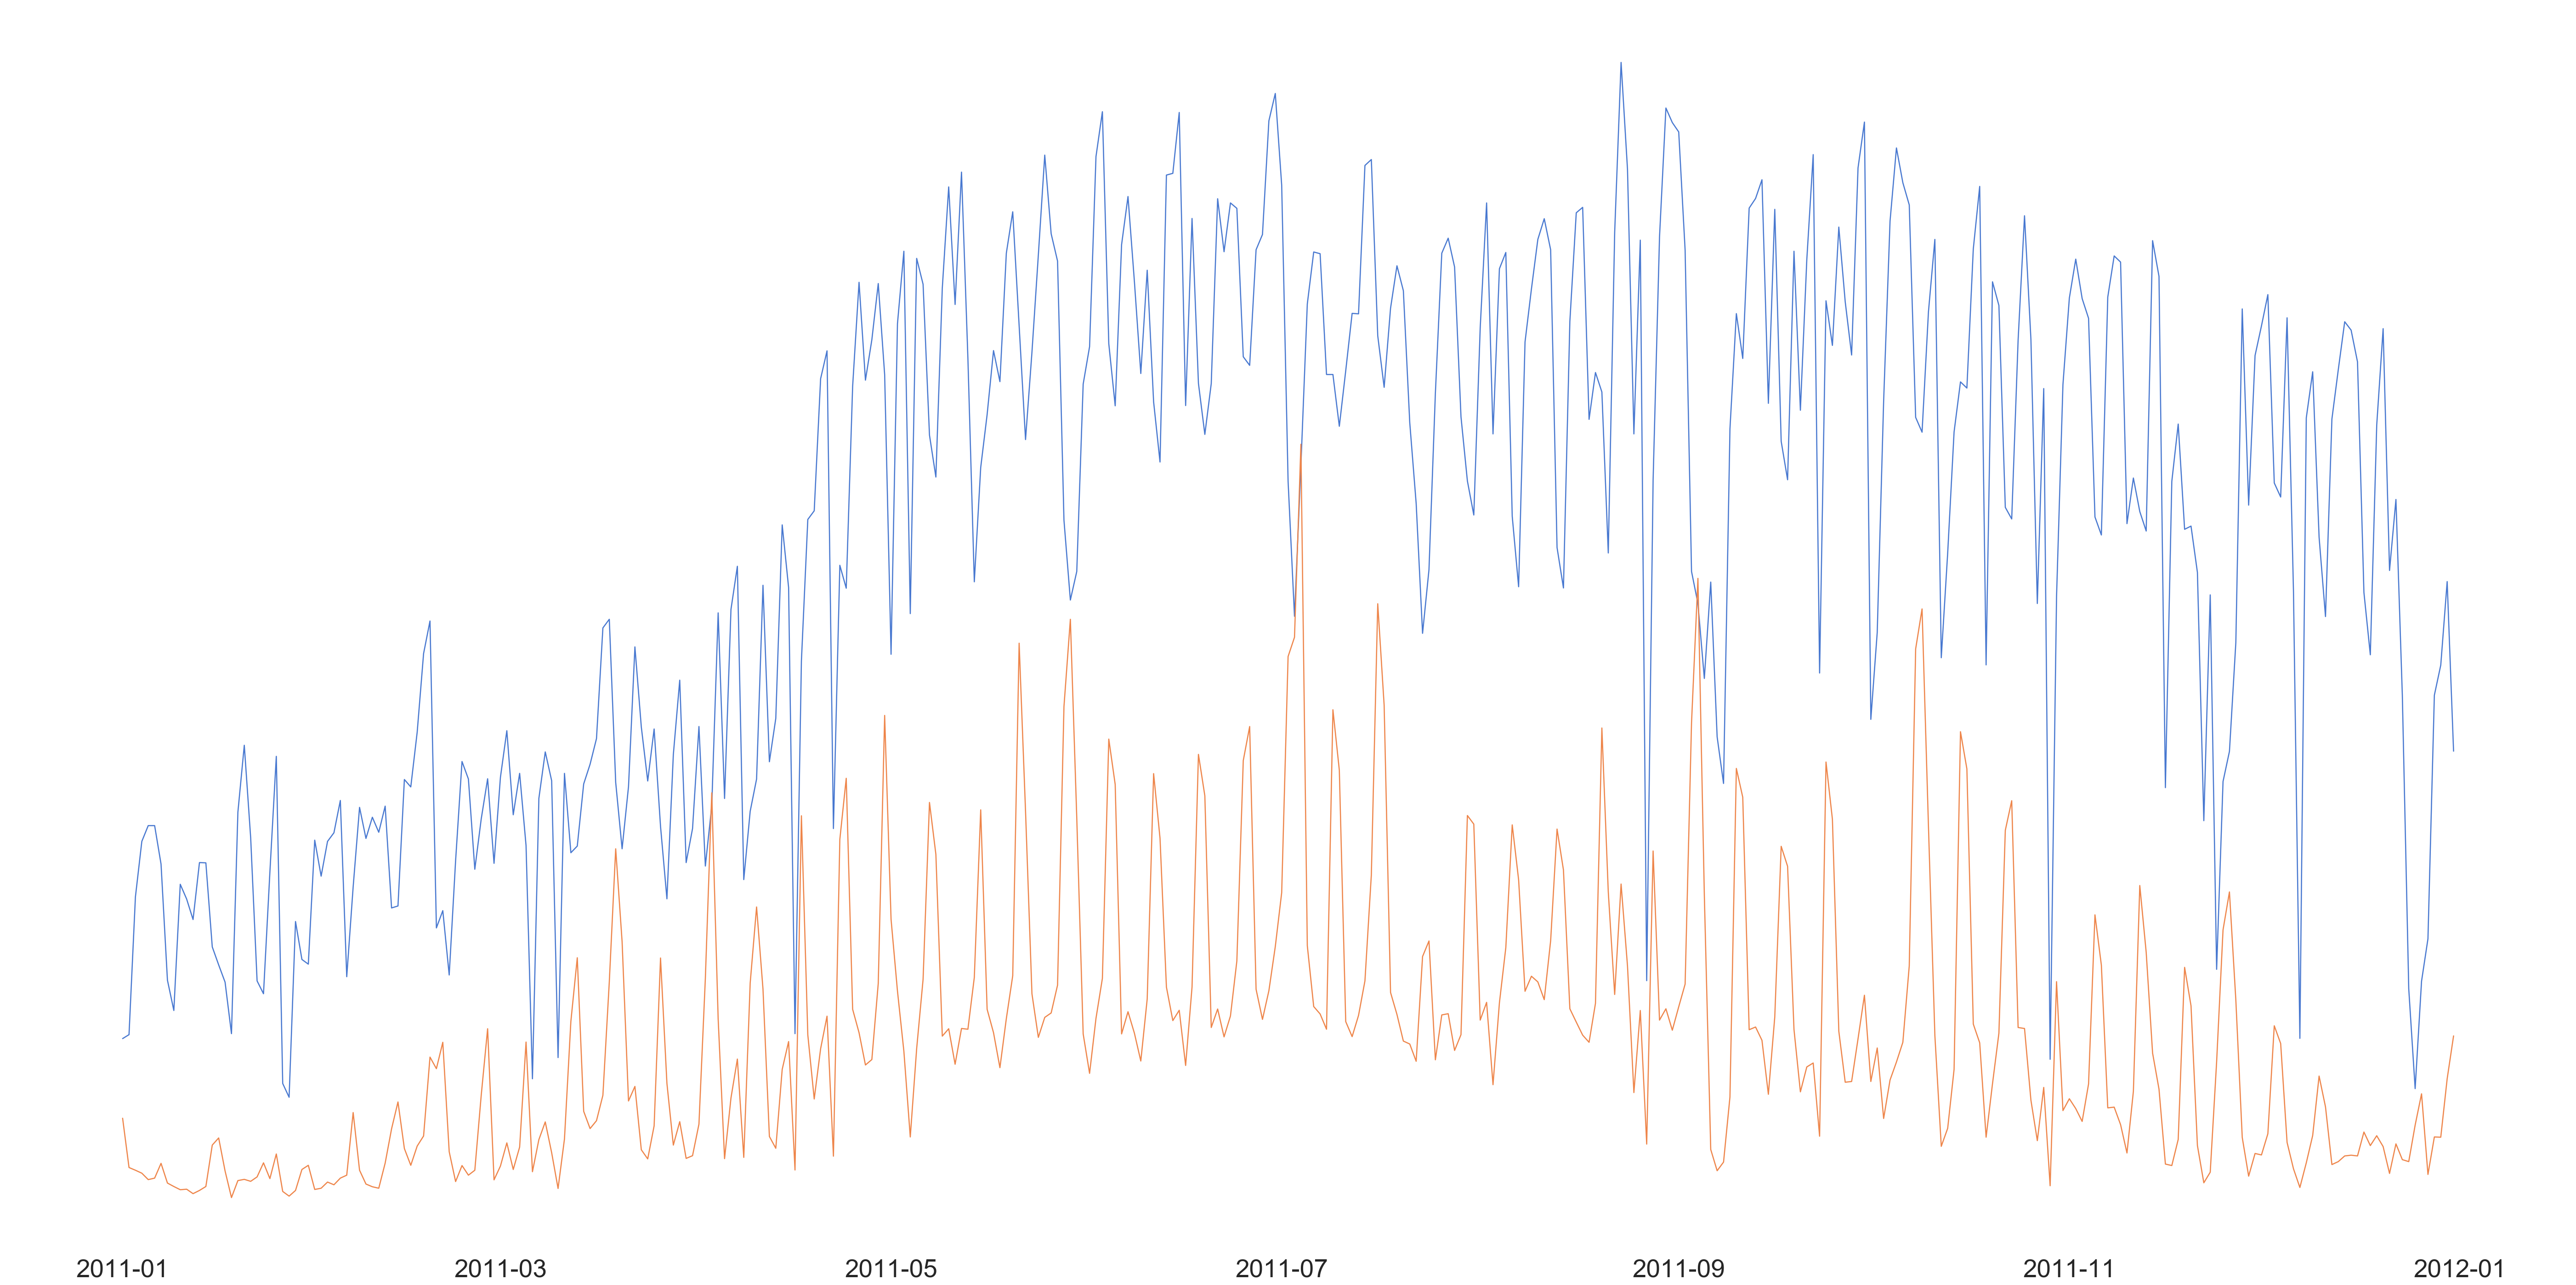

In [14]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# use seaborn to plot the registered user and casual user of 2011
sns.set(style="white", palette="muted", color_codes=True, font_scale=5)
f, axes = plt.subplots(1, 1, figsize=(100, 50), sharex=True)
sns.lineplot(data=dfday['2011'].registered,linewidth=2.5)
sns.lineplot(data=dfday['2011'].casual,linewidth=2.5)

# hide the edges of the plot
axes.set_yticks([])
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['bottom'].set_visible(False)



<p>&nbsp;&nbsp;&nbsp;&nbsp;As shown in the interactive plot, the unusual behavior of the data occurs mostly in the holidays(the official ones and the unofficial ones). Also there are somedays seems to have nothing to do with the holidays, so we will look into other features for some possible explanation.</p>

In [15]:
# create three traces-----lines, one for total user, one for registered, and one for casual
trace1 = go.Scatter(
    x = dfday.index,
    y = dfday.cnt,
    name = "total users",
    line = dict(color = ("purple"),width = 2.5))

trace2 = go.Scatter(
    x = dfday.index,
    y = dfday.registered,
    name = "registered users",
    line = dict(color = ("coral"),width = 2.5))

trace3 = go.Scatter(
    x = dfday.index,
    y = dfday.casual,
    name = "casual users",
    line = dict(color = ("blue"),width = 2.5))

data = [trace1,trace2,trace3]
# plot the traces, together with the layout, into the plot
layout = dict(
    title = "number of shared bike users",
#     xaxis = dict(title = "Angle in Radian"),
#     yaxis = dict(title = "date")
)
fig = dict(data = data, layout = layout)
ply.plot(fig, filename='bike_users.html')


'file:///Users/jiachaopan/Desktop/IEMBD/TERM2/PYTHON/groupproject1/script/bike_users.html'

### Weather Conditions<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;The first set of variables we think are important is the weather conditions. Thinking in a bike user's perspective, we are less likely to ride a bike when the weather conditions are extremely bad. On the other hand, when the actual weather is way much different from the expected weather, the bike users may change their approach to the other public transportations. So we are going to study the <strong>weathersit</strong> and the <strong>temp</strong> and <strong>atemp</strong> which are the theoretical temperature and the feeling temperature. As you may noticed, there are other two weather features <strong>hum</strong> and <strong>windspeed</strong>. One presents the humidity, and the another presents the windspeed. Those features are also important to the bike user's decision, but it's hard to give a threshold. So we will decide later by the correlation heatmap.</p><br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;By subtracting <strong>temp</strong> with <strong>atemp</strong>, we generate a new feature called "temp_diff", which presents the difference of feeling temperature with theoretical temperature. To visualize its impact on the bike users, we plot the new feature <font color='royalblue'>temp_diff</font> with the total number of bike users. In this plot, we didn't normalize the <font color='coral'>total number of bike users</font>, because there may be some important information. So we simply divided the total amount of user by 8000. And draw a green line as the reference for <font color='green'>value=0</font>. Instead of plotting the entire dataset, we extracted '2012-04' as a subset. Because April is the edge between spring and summer, the weather condition may be more variant than the other months. </p><br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;From the plot, we can tell that in some days, <font color='royalblue'>temp_diff</font> drops, and <font color='coral'>total bike user</font> drops as well. This means when feeling temperature is higher than the actual temperature, some of the bike users decided to not use the bike. However, in the other days(late April), the trends of the two lines moves oppositely.  Notice that, from the beginning of April to the end of the April, the overall temperature increases. One explanation is when the overall temperature changes, people behave differently.</p>

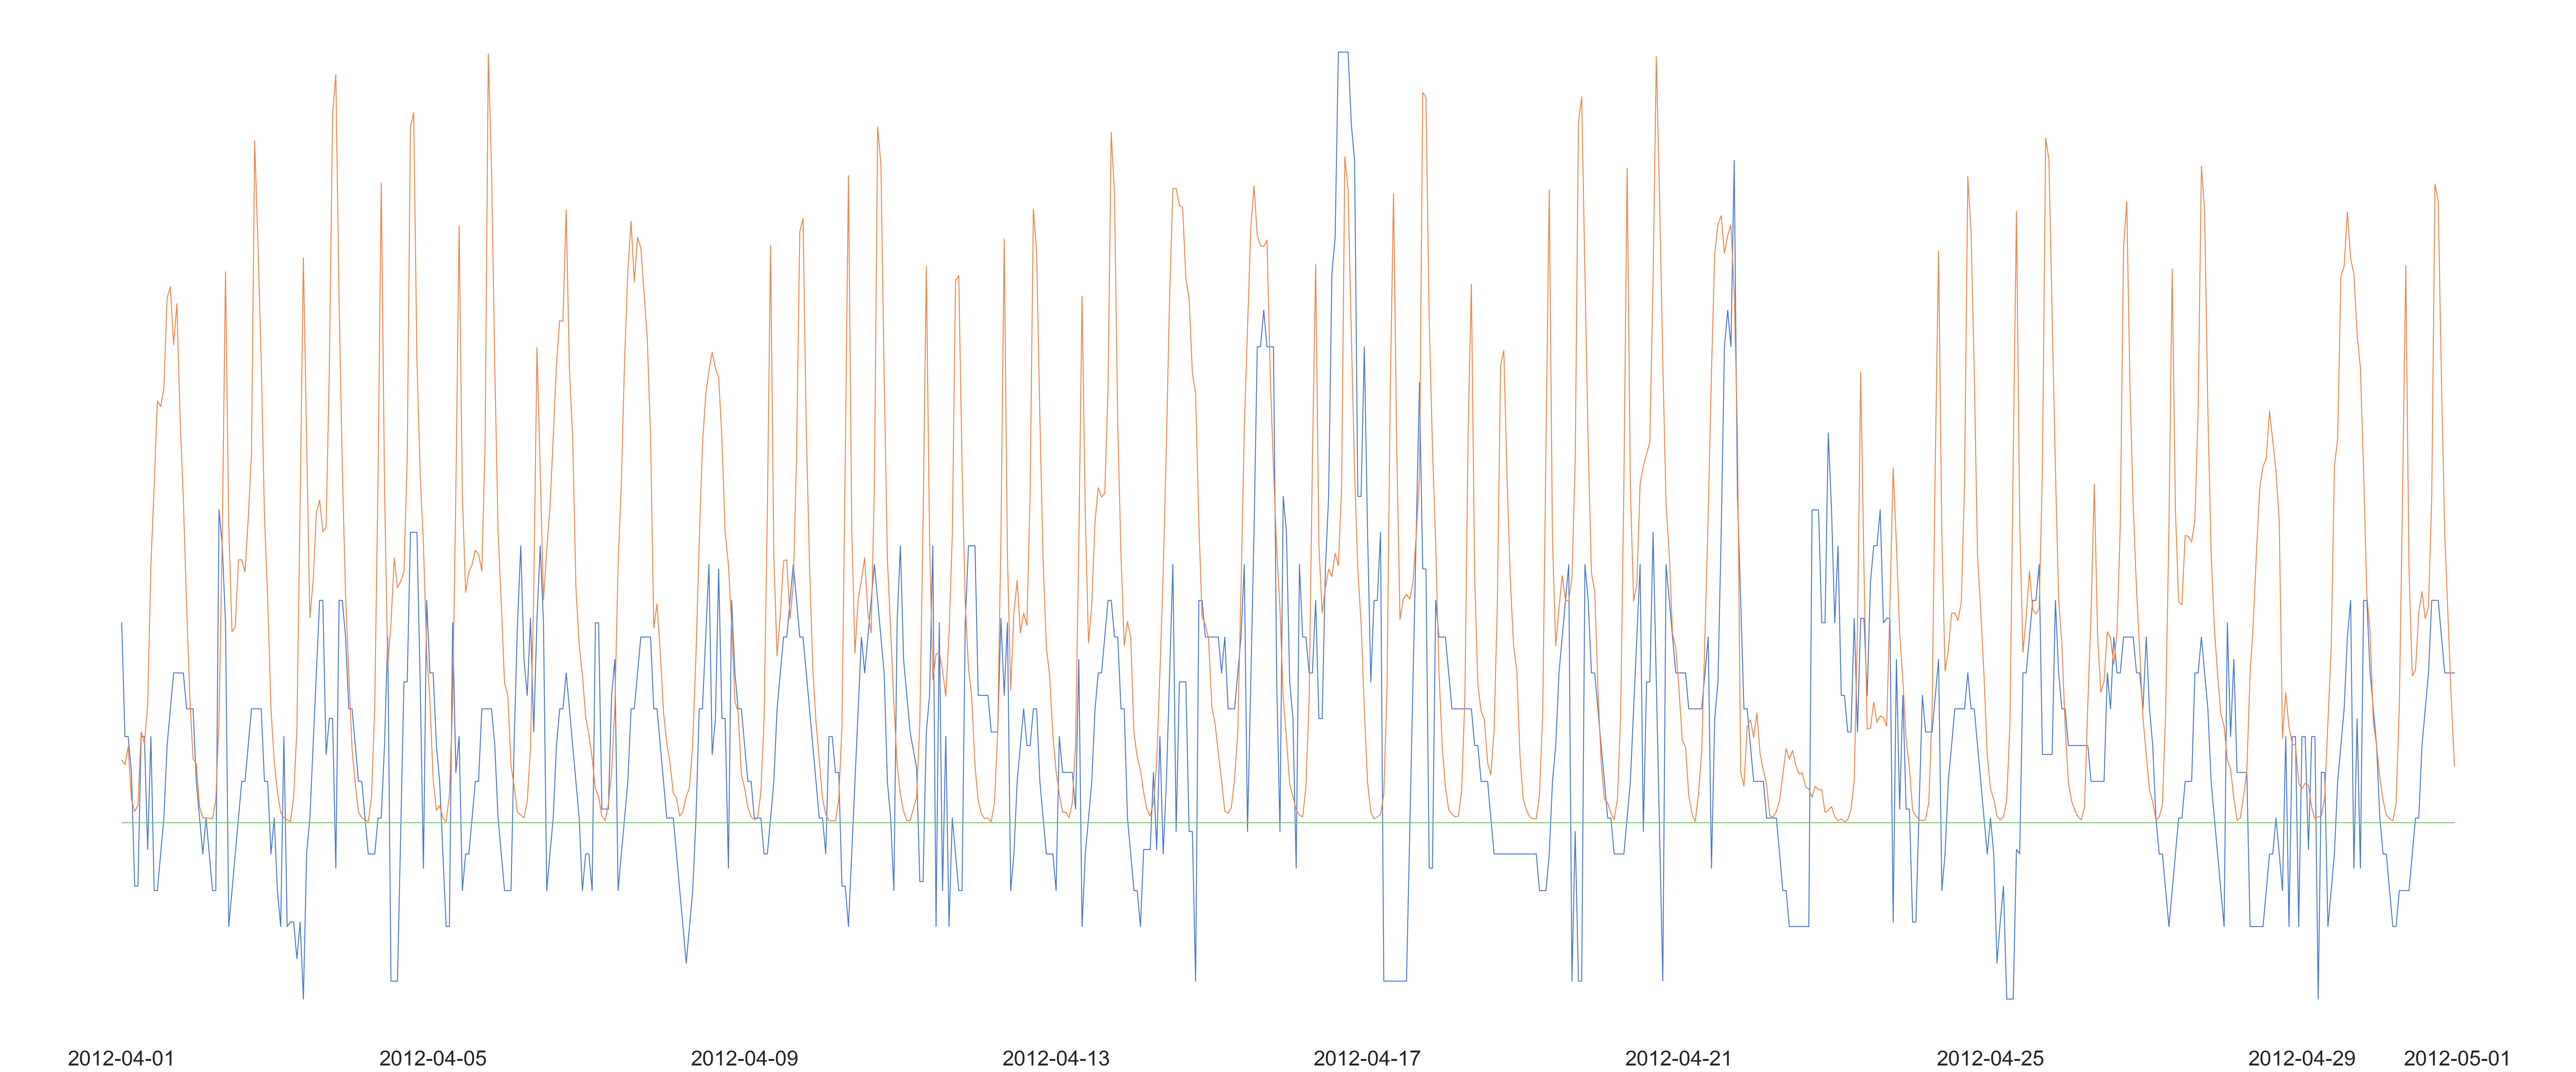

In [16]:
# create new features temp_diff = temp - atemp
dfhr['temp_diff'] = dfhr.temp - dfhr.atemp
register_matplotlib_converters()

# create seaborn multiple line plot that shares the x-axis
# in another words: display multiple lines in the same plot
# take '2012-04-01'---'2012-04-30' as an subset
sns.set(style="white", palette="muted", color_codes=True, font_scale=5)
f, axes = plt.subplots(1, 1, figsize=(120, 50), sharex=True)
sns.lineplot(data=dfhr['2012-04'].temp_diff,linewidth=2.5)
sns.lineplot(data=dfhr['2012-04'].cnt/8000,linewidth=2.5)
sns.lineplot(data=dfhr['2012-04'].temp_diff-dfhr['2012-04'].temp_diff, linewidth=2.5)
# clean up the chartjunk
axes.set_yticks([])
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['bottom'].set_visible(False)
# f.savefig("output.png")

<p>&nbsp;&nbsp;&nbsp;&nbsp;To have a better understanding of this pattern with respect to the entire dataset, we again create an interactive plot using plotly, and we look for the unusual days. </p>

In [17]:
trace_1 = go.Scatter(
    x=dfhr.dteday,
    y=dfhr.temp,
    name = "temp",
    line = dict(color = '#F39C12'),
    opacity = 0.8)

trace_2 = go.Scatter(
    x=dfhr.dteday,
    y=dfhr.atemp,
    name = "atemp",
    line = dict(color = '#3498DB'),
    opacity = 0.8)
title = 'Temprature variation in both year'

data = [trace_1, trace_2]
layout = dict(
    title=title,
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(),
        type='date'
    )
)
fig = go.Figure(data=data, layout=layout)
ply.plot(fig, filename='temp_atemp.html')


'file:///Users/jiachaopan/Desktop/IEMBD/TERM2/PYTHON/groupproject1/script/temp_atemp.html'

### Seasons<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;Besides the weather conditions, the seasons may also have strong impact on the users' decisions of riding a bike. Because the weather can be very bad in the winter, and the users may decide to take a more comfortable transportation.</p><br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;From the boxplot of the total users with respect to each season, we are able tell, for both <font color='royalblue'>2011</font> and <font color='coral'>2012</font>, there are more bike users in the second and the third season, and less bike users in the first season. However, in the second, the third, and the forth seasons, there are some outlier days, when the bike users are extremely high. To have a better understanding, we will go deep into the hourly, weekly, and monthly barchart.</p>

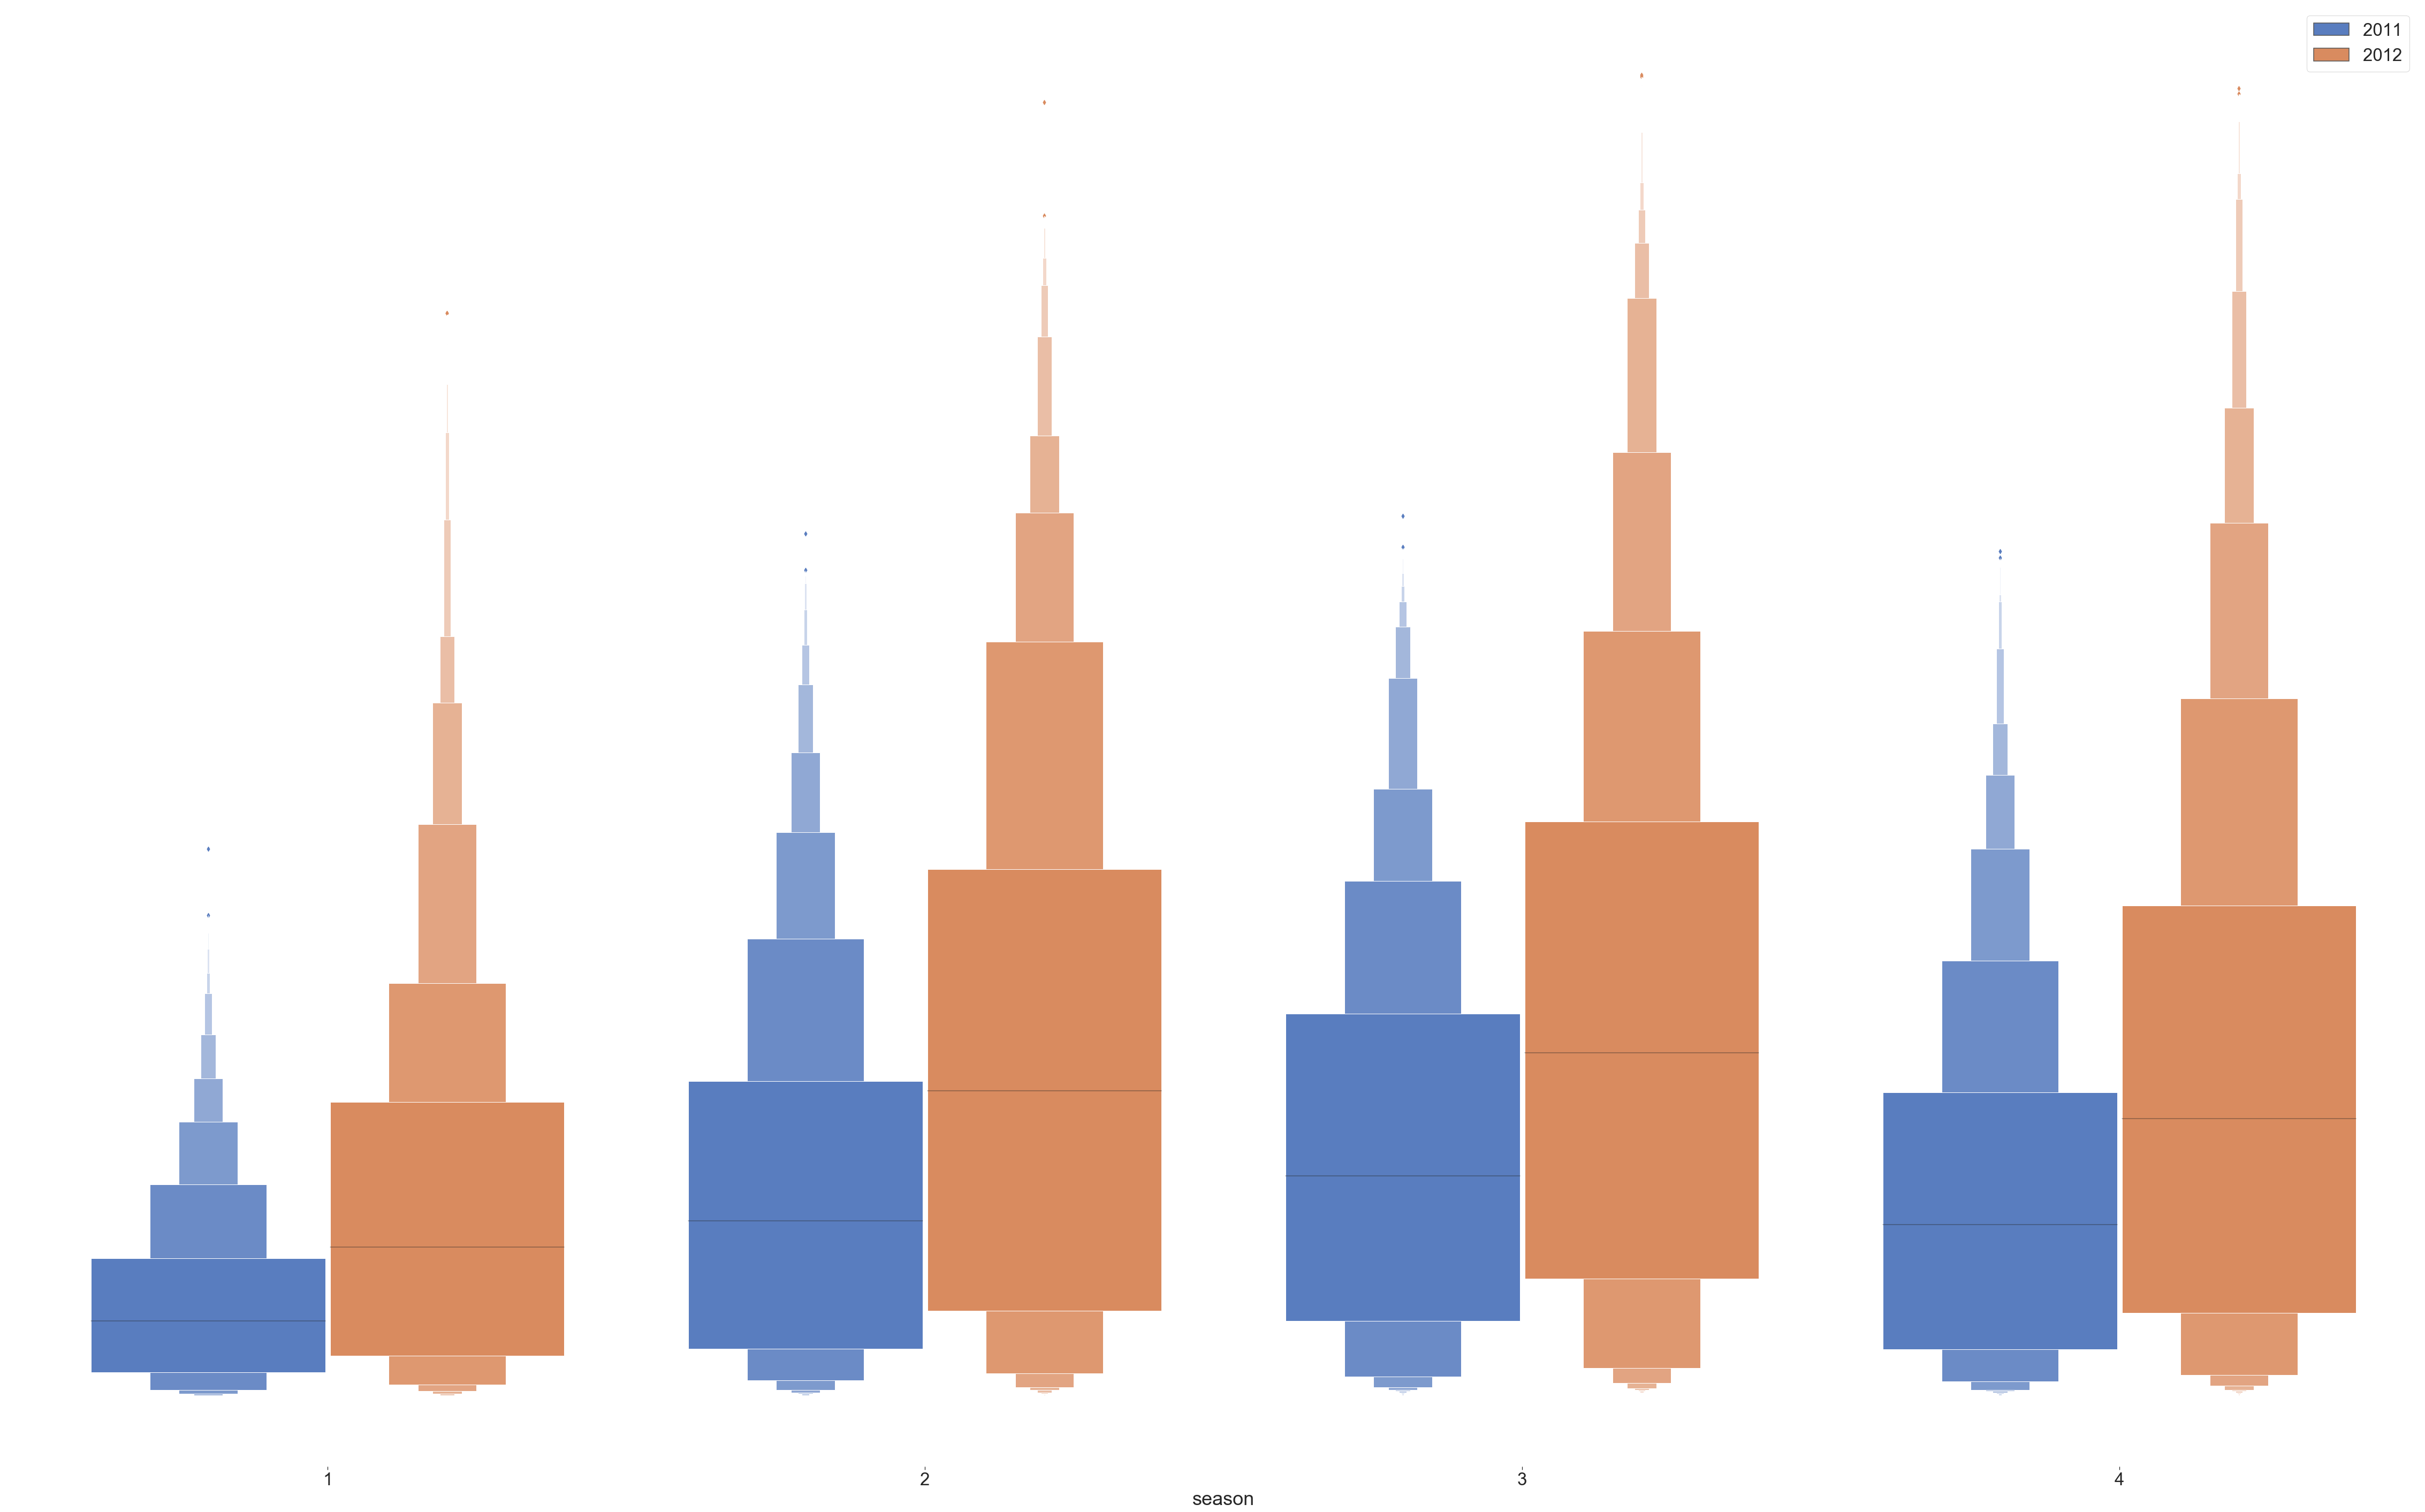

In [18]:
sns.set(style="ticks", palette="pastel",font_scale=3)
f, ax = plt.subplots(figsize=(80, 50), sharex=False, sharey=True)
sns.boxenplot(x="season", y="cnt",
            hue="yr", palette='muted',linewidth=3,scale='exponential',
            data=dfhr)
l = ax.legend()
l.set_title('')
sns.despine(offset=10, trim=True)
ax.set_yticks([])
ax.set_ylabel(' ')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["2011", "2012"])

### Hourly Histogram<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;The hourly histogram shows obvious patterns throught the day. For example, from 0 to 5 am in the morning, there are rarely any user, while from 9 to 16, there are simliar amount of bike users. In addition, from 17 to 23, the number of bike users drops every hour. This pattern may be explained by people's daily behaviors such as going to work, or school, and going back to home. Despite the year difference, the behaviors are the same. So it may be useful if we bin the hours together into smaller groups.</p>

In [19]:
def plot_timescale(df,x,y,filter_on = 'yr',legend_loc='upper left',CI_width=0):
    dfplot = df.copy()
    sns.set(style="white", font_scale=3)
    dfplot['yr'] = dfplot['yr'].map({0: '2011', 1: '2012'})
    f, ax = plt.subplots(figsize=(20, 10), sharex=False, sharey=True)
    g = sns.barplot(x=x, y=y, hue=filter_on, data=dfplot, palette="muted",errwidth=CI_width)

    if y == 'casual' or y == 'registered':
        g.set_title('number of '+y+' users')
    elif y == 'cnt':
        g.set_title('number of total users')

    l = ax.legend()
    l.set_title('')
    ax.set_yticks([])
    ax.set_ylabel(' ')
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    plt.legend(loc=legend_loc)

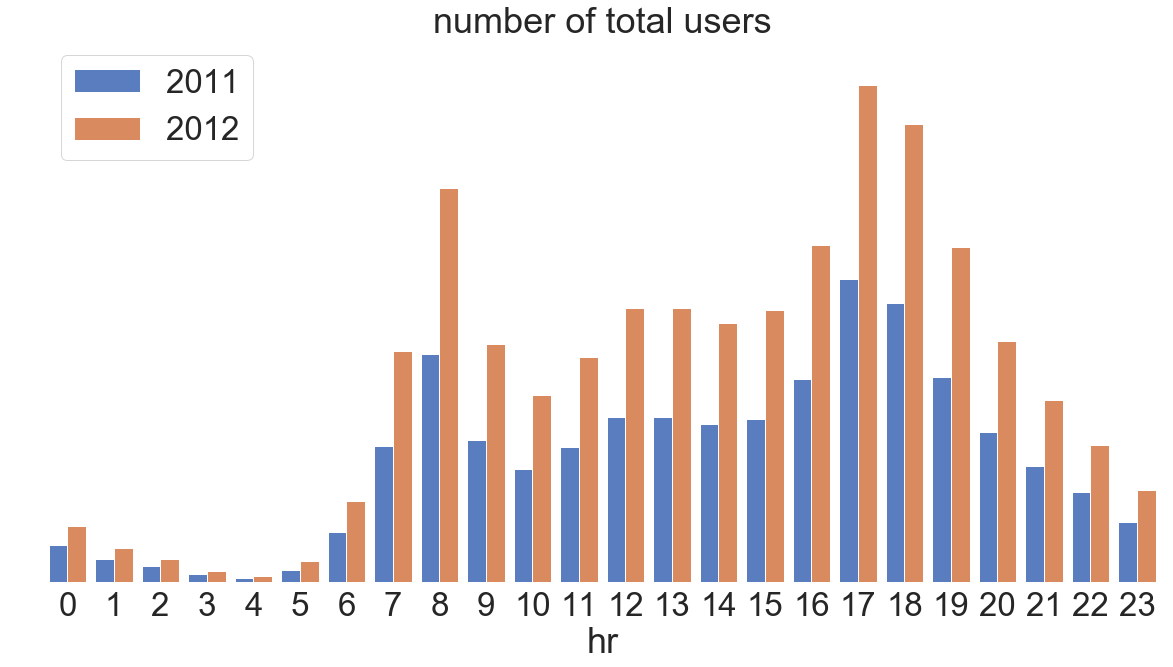

In [20]:
plot_timescale(dfhr,'hr','cnt')

<p>&nbsp;&nbsp;&nbsp;&nbsp;As we dive into the different types of bike users, we observe that the user behaviors are different. The number of casual users continously increases from 6 to 15 and then drops until 5 am in the morning of the next day. The number of registered users behaves more like the total number of bike users, because the registered users are proximately 95% of the total users.</p>

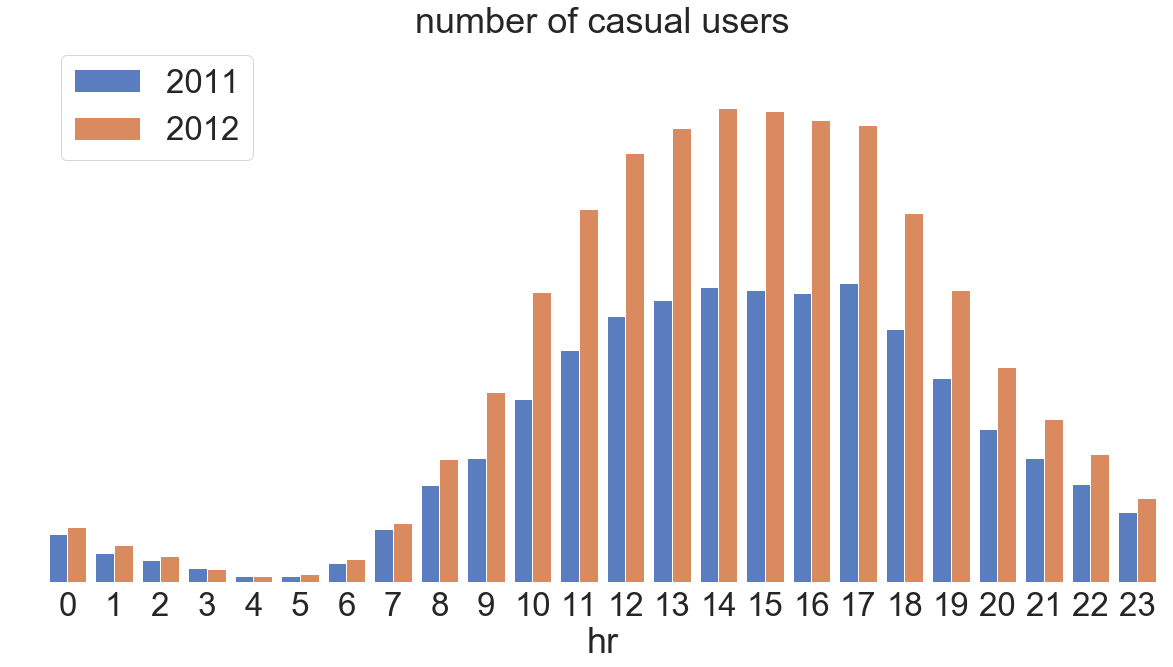

In [21]:
plot_timescale(dfhr,'hr','casual')

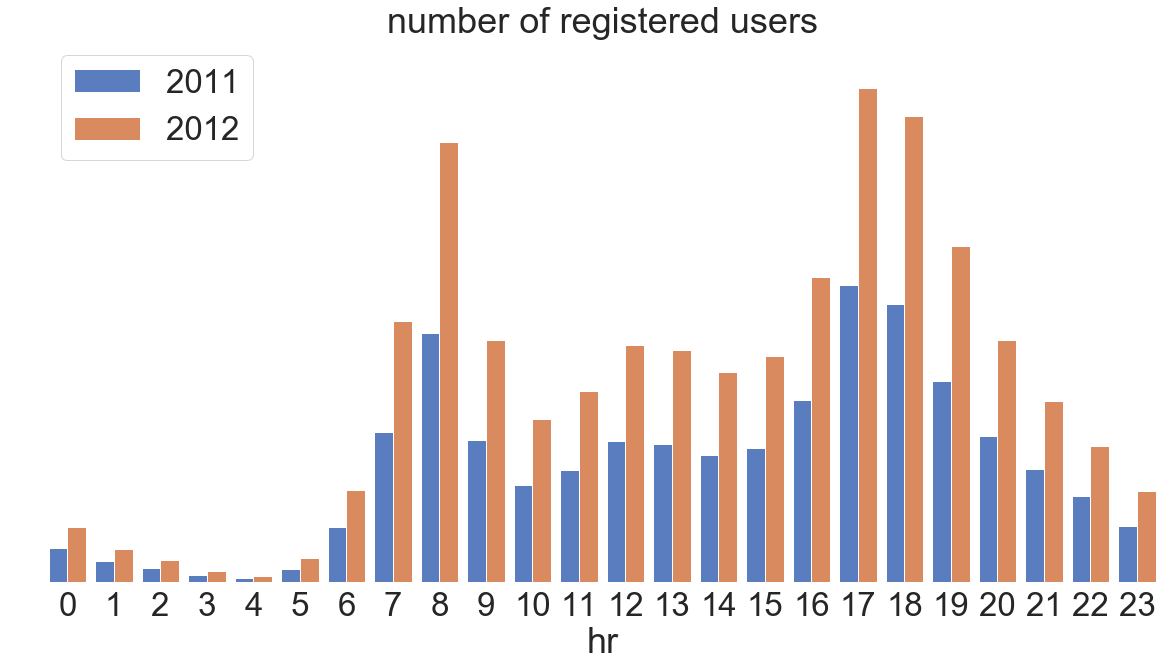

In [46]:
plot_timescale(dfhr,'hr','registered')

### Monthly Histogram<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;The monthly histograms give an insight about the seasonality of the data. The peaks appears at June and September, while the dips appears in Januaray and December. However, comparing to the data between 2011 and 2012, we detect that, in August, September, and October of 2012, the number of bike users are more than the number of the same month in the previous year. However, with only two years of data, we can not judge if it's normal or not.</p>

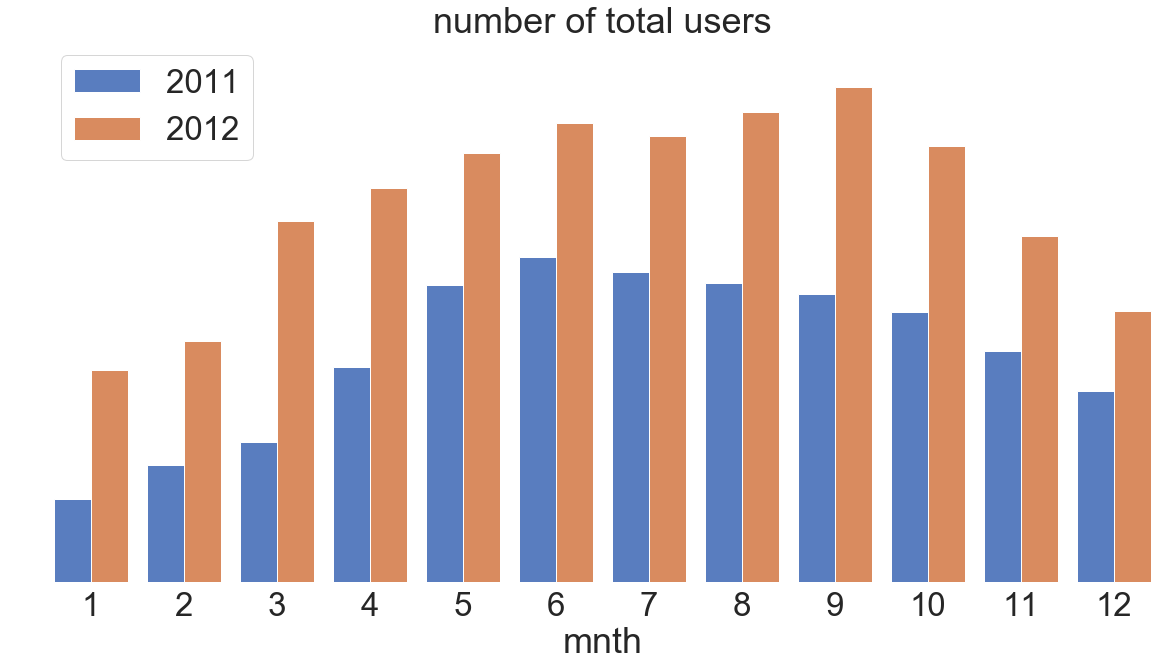

In [22]:
plot_timescale(dfday,'mnth','cnt')

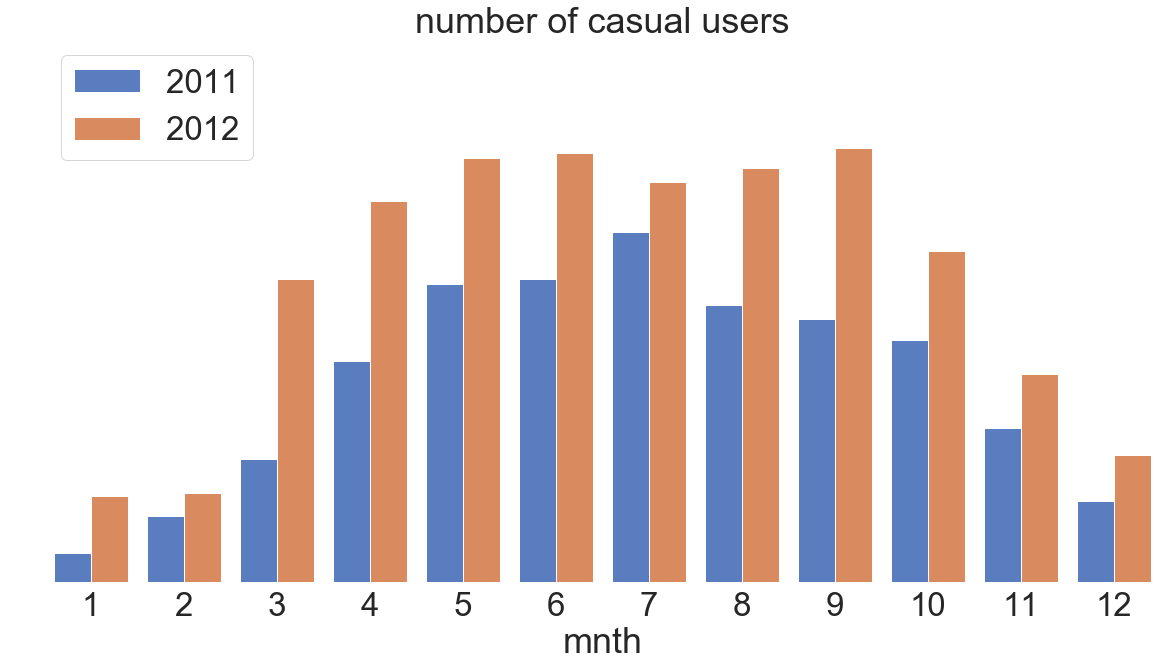

In [23]:
plot_timescale(dfday,'mnth','casual')

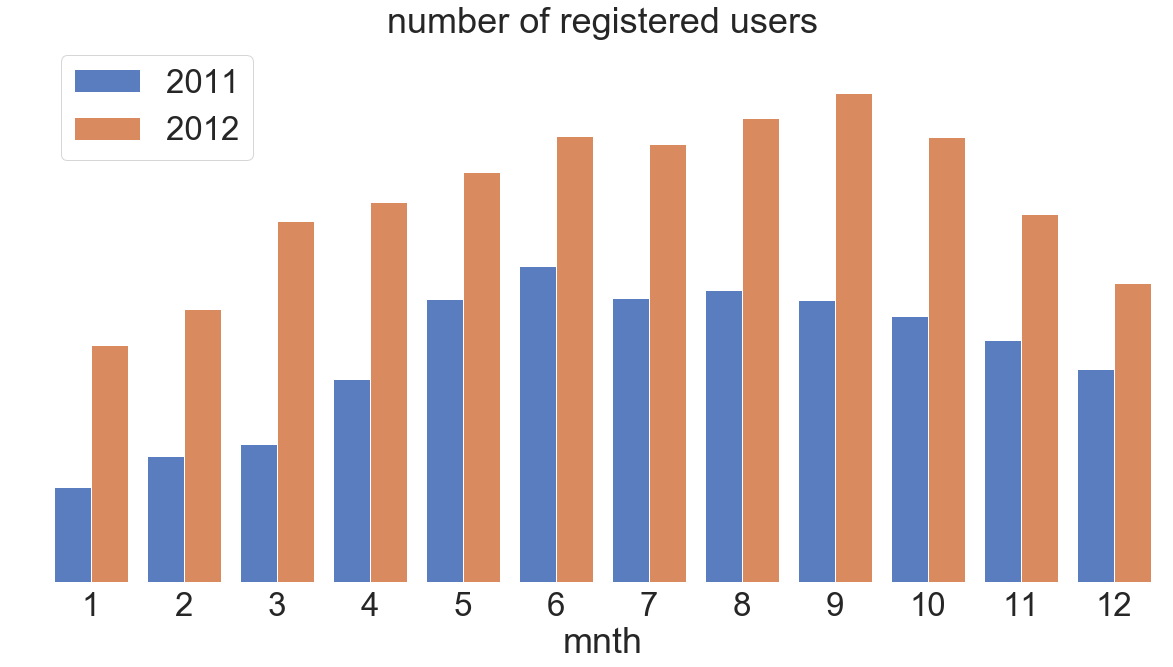

In [24]:
plot_timescale(dfday,'mnth','registered')

### Bike Users Polar Plots<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;The four polar plots below show the bike users' behaviors under different weather conditions. Each of the four plots presents the four conditions of weather, from extremely good to extremely bad, in numerical scale from 1 to 4. While the 360° of each plot presents the 24 hours of a day, the hours start at the right side of every polar plot, where is 0° .</p><br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;Comparing to each plot, the users' behaviors are similar except in the fourth plot, in which the weather condition is extremely bad. In the fourth plot, the bike users appears only in two hours, one is 4, another is 13. So in this case, we may consider the 4th weather condition as an outlier because of its special situation.</p><br>

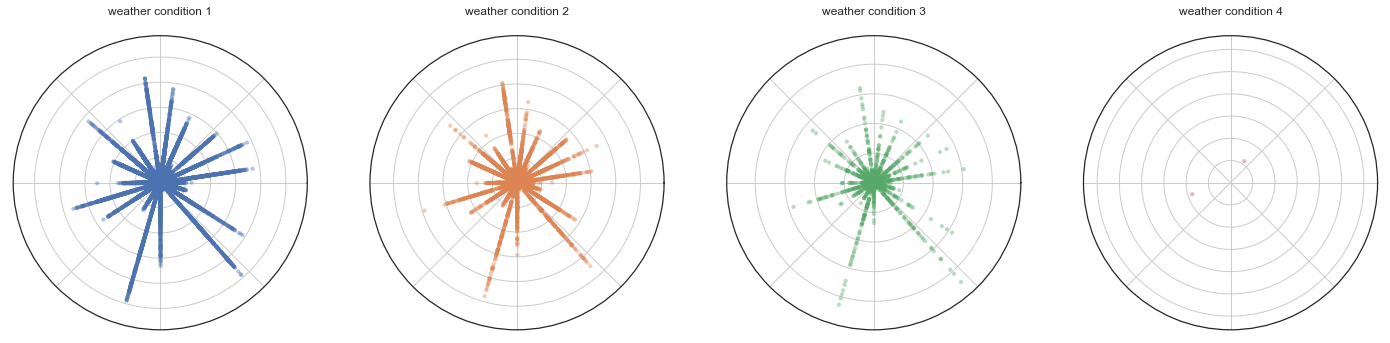

In [26]:
sns.set(style='white')
# Set up a grid of axes with a polar projection
g = sns.FacetGrid(dfhr, col="weathersit", hue="weathersit", margin_titles=False,
                  subplot_kws=dict(projection='polar'), height=5,
                  sharex=False, sharey=False, despine=False)

# Draw a scatterplot onto each axes in the grid
g.map(sns.scatterplot, "hr", "cnt",alpha=0.4, size=3,edgecolor='')
g.set_titles("weather condition {col_name}")
g.set_xlabels("")
g.set_ylabels("")
g.set_xticklabels([])
g.set_yticklabels([])
plt.show(g)


### Correlation Matrix<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;Since we have numerical features for weathers and target variables, we can visualize a correlation matrix to detect the relationship between each of the variables.</p><br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;As shown from the heatmap, cnt is highly correlated with casual and registerd. The weather features, temp, atemp, and hum also have relatively high correlation with registered, casual, and cnt. Comparing to the correlation with registered, the correlation of weather conditions with casual is a bit higher. This is possibly because weather conditions matters more for the casual users than for the registered users. In addition, temp and atemp are highly correlated to each other.</p><br>

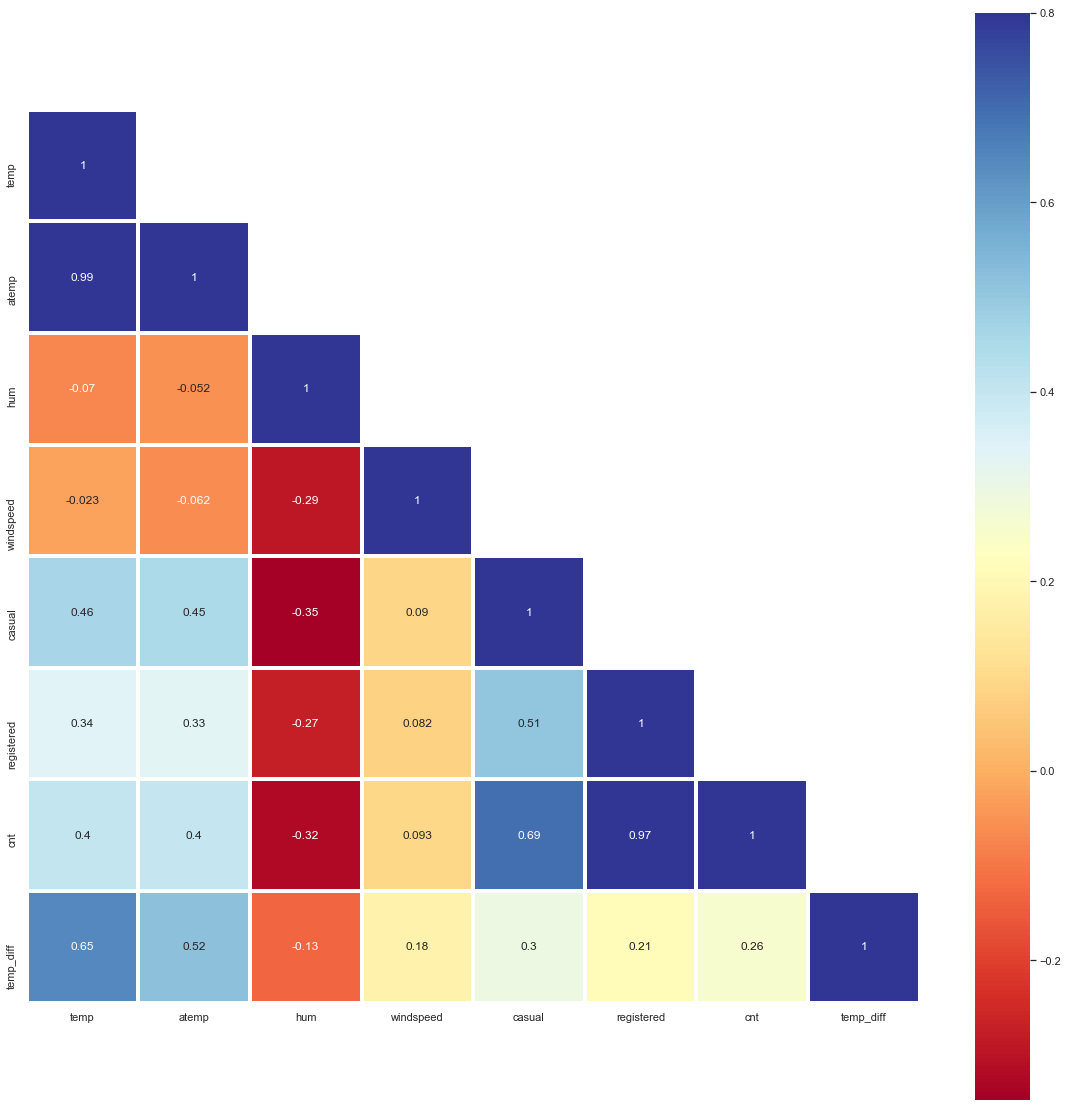

In [27]:
# create correlation matrix
corr_matrix = dfhr.corr()
# create a mask from correlation matrix
mask = np.array(corr_matrix)
# return the lower triangle of the matrix by setting the mask of the lower triangle to be false
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots(figsize=(20,20))
# plot correlation matrix to heatmap
sns.heatmap(corr_matrix,
            cmap='RdYlBu',
            mask=mask,
            vmax=.8, 
            square=True,
            annot=True,
            linewidths=3,
            ax=ax)
plt.show(fig)

<a id="BaselineModel"></a>
## 3. Baseline Model<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;In the modeling part, we will try different models such as Linear Regression, Random Forest, and Gradient Boost. In addition, we will use R-square as the metric for the model performance, because the target variable is numerical variable. Roughly speeking, R-square present, in percentage, how much the model explains the numerical changes on the target variable. </p><br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;We will consider two scenarios. One scenario is predicting the real time total number of bike users. In thin scenario, we will be able to obtain the hourly registered bike users immediately, because the registered users are able to access the bike with their devices, and it's easier to track the data. So we include <strong>registered</strong> as one of our features in the modeling. The another scenario is forecasting the bike usages for next hours, days, and months, so that the company can come up with different strategies, not only in transporting bikes but also in marketing operations, to keep the balance between the number of bikes available and the number of bikes demanded.</p><br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;For every model we are going to obtain, we will build one pipeline, so that we can process the data before running the model. For categorical variables, we will apply <strong>One Hot Encoder</strong>. For numerical variables, we use <strong>Standard Scaler</strong> to scale all the numerical features based on how many standard deviation the values of the features are away from their own mean.</p>


<a id='SplitData'></a>
### Split Dataset<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;Based on the fact the dataset is timeseries, we should only split dataset based on timeline, so that we don't use future data to predict the past observations. In this case, we leave the last quarter of 2012 out as the holdout dataset, and use the rest as training set. Further in the cross validation part, we will use timeseries split to split the dataset again into training and testing.</p><br>


In [28]:
def splitdata(dfo, exclude, createLag = True,target_col='cnt'):
    """
    dfo: the original dataset.
    exclude: the features to exclude from the sample dataset, which are the ones we don't want to include into our modeling part.
    createLag: a boolean whether we decide to create the lag or not, default True.
    target_col: our target feature, default is 'cnt', the main reason of introducing this variable is in case we are going to build model to predict 'casual' or 'registered'.
    """
    df = dfo.copy()
    # a function to create a lag with respect to the target column
    if createLag == True:
        df['Lag24'] = df[target_col].shift(24)
        df['Lag1'] = df[target_col].shift(1)
        df['Lag2'] = df[target_col].shift(2)
        df['Lag3'] = df[target_col].shift(3)
        df['Lag23'] = df[target_col].shift(23)
        df['Lag10'] = df[target_col].shift(10)

        df = df.dropna()
    else:
        df = df
    # taking 2011-01-01 to 2012-09-30 as sample, leaving the last quarter of 2012 for holdout
    sample = df.loc['2011-01-01':'2012-09-30']
    holdout = df.loc['2012-10-01':'2012-12-31']
    sample_y = sample[[target_col]]
    sample_X = sample.loc[:, sample.columns.difference(exclude)]
    holdout_y = holdout[[target_col]]
    holdout_X = holdout.loc[:, holdout.columns.difference(exclude)]
    return sample_X, sample_y, holdout_X, holdout_y

### Baseline Linear Model<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;As shown from the baseline linear model, the model for the first scenario performed 97.5% on R-square, which is very good. While for the second scenario, the model only performed 63% on R-square.</p>

In [29]:
def lrmodel_baseline(df,exclude,lags=True):
    sample_X, sample_y, holdout_X, holdout_y = splitdata(df,exclude,lags)

    # determine the categorical features from the sample_X
    categorical_features = sample_X.dtypes == 'category'
    # determine the numerical features from the sample_X
    numerical_features = ~categorical_features
    # create a list of estimators in which ColumnTransformer process different types of features
    # using linear regression as our model
    estimators = [   
                        ('ctf',ColumnTransformer([
                                    ('scale',StandardScaler(),numerical_features),
                                    ('enc',OneHotEncoder(categories='auto'),categorical_features)])),
                        ('lr',LinearRegression())
                ]

    pipe = Pipeline(estimators)       
    model = pipe.fit(sample_X,sample_y)
    score_test = model.score(holdout_X,holdout_y)
    print('Holdout dataset model R2 is: %s'%(str(score_test)))

In [30]:
print('Baseline Model with Registered, no Casual:')
exclude = ['cnt','casual','dteday']
lrmodel_baseline(dfhr,exclude,lags=False)
print('--------------------------------------------')
print('Baseline Model with no Registered, no Casual:')
exclude = ['cnt','casual','dteday','registered']
lrmodel_baseline(dfhr,exclude,lags=False)

Baseline Model with Registered, no Casual:
Holdout dataset model R2 is: 0.9753949513928504
--------------------------------------------
Baseline Model with no Registered, no Casual:
Holdout dataset model R2 is: 0.6373368591197548


### Baseline Random Forest Model<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;As shown from the baseline random forest model, the model for the first scenario performed 98.3% on R-square, which is very good. While for the second scenario, the model only performed 82.5% on R-square.</p>

In [35]:
def model_rf_baseline(dfX,exclude,lags=True):
    tscv = TimeSeriesSplit(n_splits=3)
    sample_X, sample_y, holdout_X, holdout_y = splitdata(dfX,exclude,lags)
#     print(sample_X.shape)
    print('-------------------------------------------------------------------------------')
    # print the features will be used in the model
#     print('features for modeling',sample_X.columns)
    
    categorical_features = sample_X.dtypes == 'category'
    numerical_features = ~categorical_features
    estimators = [   
                    ('ctf',ColumnTransformer([
                                ('scale',StandardScaler(),numerical_features),
#                                 ('PCA',PCA(),numerical_features),
                                ('enc',OneHotEncoder(categories='auto',handle_unknown='ignore'),
                                         categorical_features)])),
#                     ('poly', PolynomialFeatures(degree=1, include_bias=False, interaction_only=True)),
                    ('rf',RandomForestRegressor(n_estimators=20,random_state=666,n_jobs=-1))]
    
    pipe = Pipeline(estimators)
    param_RF = {}
    gridPipe = GridSearchCV(pipe, param_RF, cv=tscv, n_jobs=-1,return_train_score=True)
    
    model = gridPipe.fit(sample_X,sample_y)
    score_test = model.score(holdout_X,holdout_y)
    
    print('average training R2 score is %s'%(str(model.cv_results_['mean_train_score'])))
    print('Holdout dataset model R2 is: %s'%(str(score_test)))
    return model

In [37]:
print('Baseline Model with Registered, no Casual:')
exclude = ['cnt','casual','dteday']
model1 = model_rf_baseline(dfhr,exclude,lags=False)
print('Baseline Model with no Registered, no Casual:')
exclude = ['cnt','casual','dteday','registered']
model2 = model_rf_baseline(dfhr,exclude,lags=False)

Baseline Model with Registered, no Casual:
-------------------------------------------------------------------------------


/anaconda3/envs/intro_python/lib/python3.7/site-packages/sklearn/pipeline.py:267: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



average training R2 score is [0.99795553]
Holdout dataset model R2 is: 0.982989287600245
Baseline Model with no Registered, no Casual:
-------------------------------------------------------------------------------


/anaconda3/envs/intro_python/lib/python3.7/site-packages/sklearn/pipeline.py:267: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



average training R2 score is [0.9843041]
Holdout dataset model R2 is: 0.8251017188852717


### Baseline Random Forest Model<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;As shown from the baseline gradient boost model, the model for the first scenario performed 98.6% on R-square, which is very good. While for the second scenario, the model only performed 66.9% on R-square.</p>

In [38]:
def model_gb_baseline(dfX,exclude,lags=True,warm_start=True,target_col='cnt'):
    tscv = TimeSeriesSplit(n_splits=5)
    sample_X, sample_y, holdout_X, holdout_y = splitdata(dfX,exclude,lags,target_col=target_col)
    print('-------------------------------------------------------------------------------')

#     print('features for modeling',sample_X.columns)
    categorical_features = sample_X.dtypes == 'category'
    numerical_features = ~categorical_features
    estimators = [   
                    ('ctf',ColumnTransformer([
                                ('scale',StandardScaler(),numerical_features),
                                ('enc',OneHotEncoder(categories='auto',handle_unknown='ignore'),
                                         categorical_features)])),
                    ('gb',GradientBoostingRegressor(warm_start=warm_start,random_state=666))
                ]
    pipe = Pipeline(estimators)
    param_RF = {}
    gridPipe = GridSearchCV(pipe, param_RF, cv=tscv, n_jobs=-1, return_train_score=True)
    
    model = gridPipe.fit(sample_X,sample_y)
    score_test = model.score(holdout_X,holdout_y)
    
    print('average training R2 score is %s'%(str(model.cv_results_['mean_train_score'])))
    print('Holdout dataset model R2 is: %s'%(str(score_test)))
    return model

In [39]:
print('Baseline Model with Registered, no Casual:')
exclude = ['cnt','casual','dteday']
model1 = model_gb_baseline(dfhr,exclude,lags=False)
print('Baseline Model with no Registered, no Casual:')
exclude = ['cnt','casual','dteday','registered']
model2 = model_gb_baseline(dfhr,exclude,lags=False)

Baseline Model with Registered, no Casual:
-------------------------------------------------------------------------------


/anaconda3/envs/intro_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



average training R2 score is [0.988212]
Holdout dataset model R2 is: 0.9865933996992471
Baseline Model with no Registered, no Casual:
-------------------------------------------------------------------------------


/anaconda3/envs/intro_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



average training R2 score is [0.80002064]
Holdout dataset model R2 is: 0.6693089282851175


### Quick Summary For Baseline Models<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;As shown from the result, the gradient boost model performs the best on both scenarios, linear regression is much faster than any other models, Random Forest is intermediate. For the first scenario, we already achieved 98.6% with Gradient Boost. We are going to propose the linear regression at this moment, because it is computationally cost-efficient. For the second scenario, we are going to apply feature engineering on all of the three. Because, at this moment, we don't know if the feature engineering will change our preference. </p>


<a id="FeatureEngineering"></a>
## 4. Feature Engineering<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;As indicated in the data visualization part, we are going to mainly focus on two approaches, the timeseries structure(daily pattern, weekly pattern or monthly pattern), and the weather condition influence.</p><br>
<p>In order to capture the timeseries structure, we are also going to introduce the lags as some of the new features. For example, the number of bike users at yesterday's 10 am may be a good reference of the number of bike users today at 10 am.(The code is in the same function as the split data function.)</p><br>

### Extract Date information<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;We tried to extract the date information, from day 1 to day 30 or 31, out of the data, because the users behaves differently in different days of the same month. The major risk of doing that is causing overfitting.</p>

In [14]:
dfhr['day'] = dfhr.dteday.apply(lambda x: x.day)
dfhr.day = dfhr.day.astype('float64')

In [40]:
### Function to Bin the categories.
def cut2cat(data,tagcol,thebin,droptag=True):
    df = data.copy()
    # use pd.cut function can attribute the values into its specific bins
    Cat = pd.cut(data[tagcol],bins=thebin).to_frame()
    # create new columns based on the input variable
    new_column_name = tagcol[0:3] + 'Interval'
    # rename the extracted pd.series
    Cat.columns = [new_column_name]
    # merge with the original dataset
    df = pd.concat([data,Cat],axis = 1)
    # unfold the created categorical feature
    CatUnfold = pd.get_dummies(df[new_column_name],prefix=new_column_name)
    CatList = CatUnfold.columns
    # drop the created feature, and drop the last category
    CatUnfold = CatUnfold.drop(CatList[-1],axis=1)
    df = df.drop(new_column_name, axis = 1)
    if droptag == True:
        df = df.drop(tagcol, axis = 1)
    # merge with original dataset, and convert the datatype to category
    df = pd.concat([df,CatUnfold],axis = 1)
    df[CatList[:-1]] = df[CatList[:-1]].apply(lambda x: x.astype('category'))

    return df


### Clustering the weather conditions<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;As mentioned in the visualization part, temperature and feeling temperature are different, and sometimes can change the bike user's decision. Besides creating a new feature temerature difference(temp_diff = temp - atemp), we can also apply cluster technique to the two features, <strong>temp</strong> and <strong>atemp</strong>.</p><br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;As shown in the visualization of the clusters, we can tell that most of the days, temperature and feeling temperature are similar. However, there are few days the temperature and feeling temperature have big difference. Considering these days as some special weather conditions that may or may not been included in the feature <strong>weathersit</strong>, we create a new variable by grouping the clusters into two groups, one group with abnormal days, and the another group with regular days.</p><br>

In [41]:
# assign number of clusters, and subset the features to cluster
s = 4
weatherCluster = ['atemp','temp']
weatherdf = dfhr.loc[:, weatherCluster]
# use SpectralClustering for cluster, referring to the guide in sklearn
#https://scikit-learn.org/stable/modules/clustering.html
spec = SpectralClustering(n_clusters=s,n_init=10, random_state=666, n_jobs=-1)
weatherdf['spec']=spec.fit_predict(weatherdf)


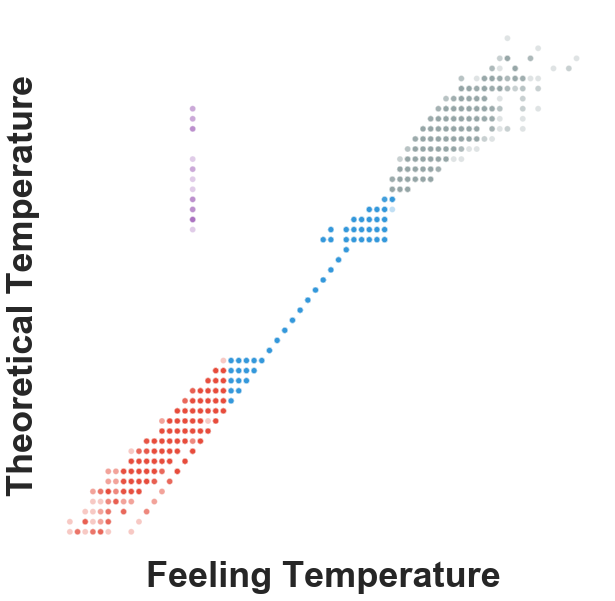

In [44]:
# create a color palette use seaborn to plot atemp and temp, color by label
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

sns.set(style='white', font_scale = 3)
f, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True)
f = sns.scatterplot(x=weatherdf['atemp'],y=weatherdf['temp'], 
                palette=flatui[:s],
                hue=weatherdf['spec'],alpha = 0.3,legend=False)
# Naming the axis
f.set_xlabel('Feeling Temperature', fontweight='bold')
f.set_ylabel('Theoretical Temperature', fontweight='bold')
f.set_yticks([])
f.set_xticks([])

# Giving Title
# f.set_title('Cluster of Temp and Atemp' , fontweight= 'bold' , fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# Display the plot
plt.show(f)

In [45]:
# define a function will be used to assign values based on the cluster label
def groupCluster(row):
    if row == 1:
        return 1
    else:
        return 0
# define the data type for the cluster feature
weatherdf['spec']=weatherdf['spec'].astype('float64')
# assign the values to the clusters
# (basically group them based on the cluster label, 1 for 1, rest for 0)
weatherdf['weather_0'] = weatherdf['spec'].apply(lambda x:groupCluster(x))
weatherdf['weather_0'] = weatherdf['weather_0'].astype('category')


### Crime Records Dataset<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;Thinking from the user's perspective, weather condition is not the only influence of the decision. It also depends on if using bike is safe or not. So we think it will be reasonable to use the additional dataset from <a href='http://opendata.dc.gov/'>the government of Washington D.C.</a> such as crime records.</p><br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;We simply counted for the number of crime incident happened in everyday, and define the day is safe or dangerous based on the number of the crime incident of the day.</p>


In [46]:
crime2011 = pd.read_csv('../data/Crime_Incidents_in_2011clean.csv')
crime2012 = pd.read_csv('../data/Crime_Incidents_in_2012clean.csv')
crime2013 = pd.read_csv('../data/Crime_Incidents_in_2013clean.csv')
crime2014 = pd.read_csv('../data/Crime_Incidents_in_2014clean.csv')
# create a list of the datasets, and concat vertically
crimelist = [crime2011, crime2012, crime2013, crime2014]
crimeUnion = pd.concat(crimelist,sort=False).reset_index(drop=True)
# drop the column
crimeUnion = crimeUnion.drop('Unnamed: 0',axis=1)
# redefine index
crimeUnion.index = pd.to_datetime(crimeUnion.START_DATE)
# take a subset of it
crime_year = crimeUnion.loc['2011':'2012']

In [47]:
# redefine index as year-month-day, original contains hours and minutes
crime_year.index = pd.to_datetime(crime_year.START_DATE).dt.date
# group by the day, in different types of 'OFFENSE', count the number of records
df_offense = crime_year.pivot_table(index=crime_year.index,columns='OFFENSE',aggfunc='size',fill_value=0)
df_offense['START_DATE_DAY'] = df_offense.index
# create a new feature which is the total crime records of the day
df_offense['TOTAL_CRIME']= df_offense['ARSON']+df_offense['ASSAULT W/DANGEROUS WEAPON']+df_offense['BURGLARY']+ df_offense['HOMICIDE']+df_offense['MOTOR VEHICLE THEFT']+df_offense['ROBBERY']+df_offense['SEX ABUSE']+df_offense['THEFT F/AUTO']+df_offense['THEFT/OTHER']

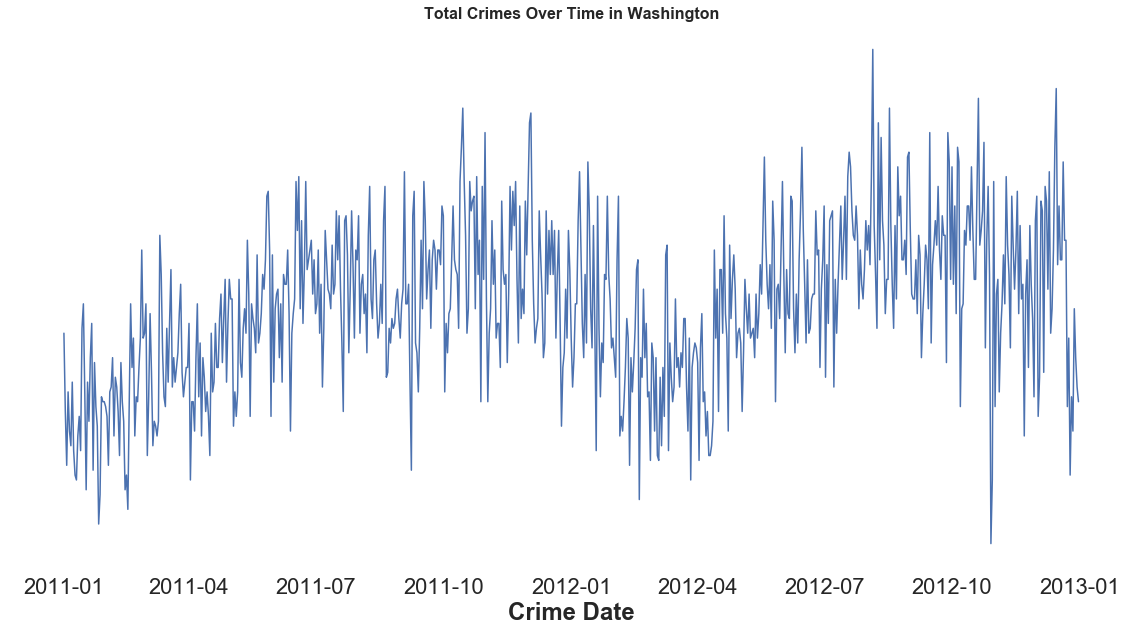

In [48]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set(style='white',font_scale=2)
f, ax = plt.subplots(figsize=(20, 10), sharex=False, sharey=True)
g = sns.lineplot(x='START_DATE_DAY', y='TOTAL_CRIME',  data=df_offense)

# Naming the axis
g.set_xlabel('Crime Date', fontweight='bold')
g.set_ylabel('', fontweight='bold')
g.set_yticks([])
# Giving Title
g.set_title('Total Crimes Over Time in Washington' , fontweight= 'bold' , fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# Display the plot
plt.show()

In [49]:
# basically here is redefine the day is safe or not with respect to the number of crime happens in a day
df_offense.loc[df_offense.ARSON <= np.mean(df_offense.ARSON), 'IS_UNSAFE_ARSON'] = 0
df_offense.loc[df_offense['ASSAULT W/DANGEROUS WEAPON'] <= np.mean(df_offense['ASSAULT W/DANGEROUS WEAPON']), 'IS_UNSAFE_ASSAULT_W/DANGEROUS_WEAPON'] = 0
df_offense.loc[df_offense.BURGLARY <= np.mean(df_offense.BURGLARY), 'IS_UNSAFE_BURGLARY'] = 0
df_offense.loc[df_offense.HOMICIDE <= np.mean(df_offense.HOMICIDE), 'IS_UNSAFE_HOMICIDE'] = 0
df_offense.loc[df_offense['MOTOR VEHICLE THEFT'] <= np.mean(df_offense['MOTOR VEHICLE THEFT']), 'IS_UNSAFE_MOTOR_VEHICLE_THEFT'] = 0
df_offense.loc[df_offense.ROBBERY <= np.mean(df_offense.ROBBERY), 'IS_UNSAFE_ROBBERY'] = 0
df_offense.loc[df_offense['SEX ABUSE'] <= np.mean(df_offense['SEX ABUSE']), 'IS_UNSAFE_SEX_ABUSE'] = 0
df_offense.loc[df_offense['THEFT F/AUTO'] <= np.mean(df_offense['THEFT F/AUTO']), 'IS_UNSAFE_THEFT_F/AUTO'] = 0
df_offense.loc[df_offense['THEFT/OTHER'] <= np.mean(df_offense['THEFT/OTHER']), 'IS_UNSAFE_THEFT/OTHER'] = 0
df_offense.loc[df_offense['TOTAL_CRIME'] <= 105, 'IS_UNSAFE_TOTAL_CRIME'] = 0

feature = ['IS_UNSAFE_ARSON','IS_UNSAFE_ASSAULT_W/DANGEROUS_WEAPON','IS_UNSAFE_BURGLARY','IS_UNSAFE_HOMICIDE',
           'IS_UNSAFE_MOTOR_VEHICLE_THEFT','IS_UNSAFE_ROBBERY', 'IS_UNSAFE_SEX_ABUSE','IS_UNSAFE_THEFT_F/AUTO','IS_UNSAFE_THEFT/OTHER',
          'IS_UNSAFE_TOTAL_CRIME']


In [50]:
# fill the missing values with 1, because in the previous step we assign values=0 for hte ones less than mean
# so here we fill the missing values of those new columns as 1
df_offense[feature] = df_offense[feature].apply(lambda x:x.fillna(1))
# at this moment we will only use the total crime records with respect to date, so we drop the rest
df_offense = df_offense.drop(['ARSON', 'ASSAULT W/DANGEROUS WEAPON', 'BURGLARY', 'HOMICIDE',
                               'MOTOR VEHICLE THEFT', 'ROBBERY', 'SEX ABUSE', 'THEFT F/AUTO',
       'THEFT/OTHER', 'TOTAL_CRIME','IS_UNSAFE_ARSON','IS_UNSAFE_ASSAULT_W/DANGEROUS_WEAPON','IS_UNSAFE_BURGLARY','IS_UNSAFE_HOMICIDE',
           'IS_UNSAFE_MOTOR_VEHICLE_THEFT','IS_UNSAFE_ROBBERY', 'IS_UNSAFE_SEX_ABUSE','IS_UNSAFE_THEFT_F/AUTO','IS_UNSAFE_THEFT/OTHER'],axis=1)

df_offense['dteday'] = pd.to_datetime(df_offense.START_DATE_DAY)
df_offense = df_offense.drop('START_DATE_DAY',axis=1)
# join the datasets
df_offense.dteday = df_offense.set_index('dteday', inplace = True)
df_with_crimes = dfhr.join(df_offense, how='left',on='dteday')

### Merge with Gas Price<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;Besides the safety, the economics is also another important part. Imaging the gas price is rapidly raised, more people are possibly going to switch from cars to bikes, or other transportations. We also found an additional dataset to add gas price information into our features.</p><br>

In [51]:
# Gasline
df_gas = pd.read_csv('../data/gas.csv')
# convert datatype and index
df_gas.Month = pd.to_datetime(df_gas.Month)
df_gas.Month = df_gas.set_index('Month', inplace = True)

# extract the year-month structure in data
df_with_crimes['Month_year'] = df_with_crimes.dteday.map(lambda x: x.strftime('%Y-%m'))
df_with_crimes.Month_year = pd.to_datetime(df_with_crimes.Month_year)

# merge dataset
df_C_G = df_with_crimes.join(df_gas, how='left', on='Month_year')
df_C_G = df_C_G.drop('Month_year',axis=1)


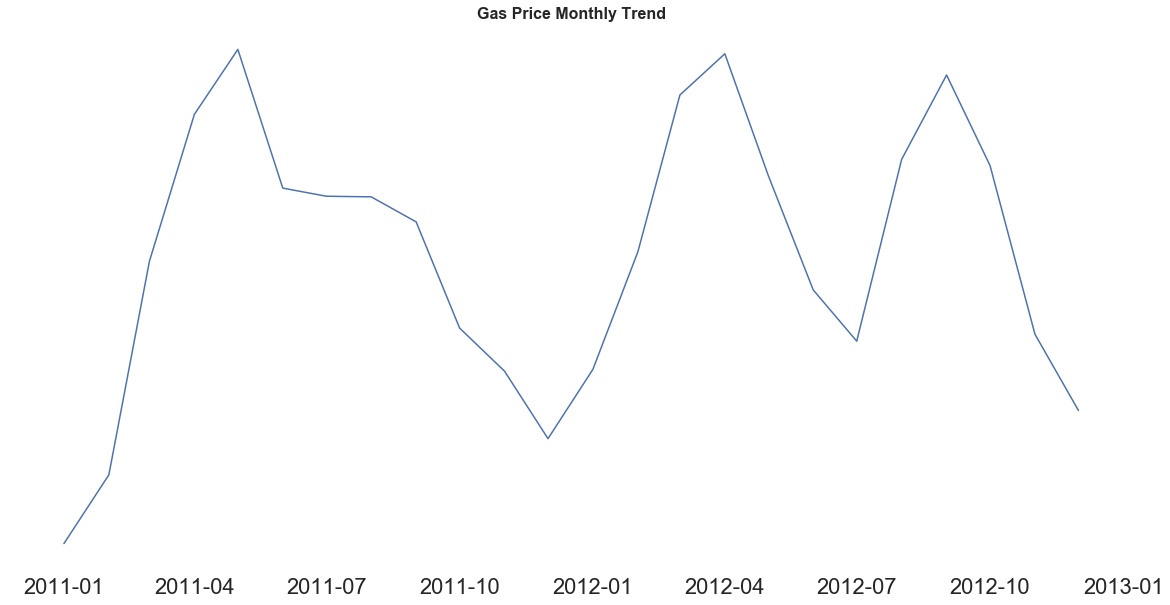

In [52]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set(style='white',font_scale=2)
f, ax = plt.subplots(figsize=(20, 10), sharex=False, sharey=True)
g = sns.lineplot(x=df_gas.index, y='Gas_Price', data=df_gas)

# Naming the axis
g.set_xlabel('', fontweight='bold')
g.set_ylabel('', fontweight='bold')
g.set_yticks([])
# Giving Title
g.set_title('Gas Price Monthly Trend' , fontweight= 'bold' , fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# Display the plot
plt.show()

### Merge with Holidays(official and unofficial)<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;Even though the original dataset already has a boolean feature describes whether it's a holiday or not, we should also take into consideration of the unofficial holidays such as Black Friday.<br>


In [53]:
# load dataset and convert datatye, assign names
holidays = pd.read_csv('../data/usholidays2.csv')
holidays = holidays[['Date','Holiday']]
holidays.Date = pd.to_datetime(holidays.Date)
holidays.columns = ['dteday','holiday_name']

In [54]:
# this function was used for create additional days before and after the holidays
# but we removed the part of creating additional days because it was not helping in the modeling
def extendholiday(holidays):
    holidayslag = holidays.copy()
    holidayslag.dteday = holidayslag.set_index('dteday', inplace = True)
    return holidayslag

holidayslag = extendholiday(holidays)
# create a new boolean feature define whether the day is holiday or not
# in here it will all be 1 because they are all holidays, but after merge, fill na with 0
holidayslag['is_holiday'] = 1
# merge datasets
df_C_G = df_C_G.join(holidayslag,how='left',on='dteday')
# define a function to fill na and convert value
def fillna_catgory(dfo,cat,navalue):
    df = dfo.copy()
    df[cat] = df[cat].fillna(navalue)
    df[cat] = df[cat].astype('category')
    return df
df_C_G = fillna_catgory(df_C_G,'holiday_name','NoHoliday')
df_C_G = fillna_catgory(df_C_G,'is_holiday',0)

# merge with the weather labels we had before
df_C_G_W = df_C_G.join(weatherdf.weather_0,how='left')
df_C_G_W.head()

dteday season yr mnth hr holiday weekday workingday  \
date_hr                                                                       
2011-01-01 00:00:00 2011-01-01      1  0    1  0       0       6          0   
2011-01-01 01:00:00 2011-01-01      1  0    1  1       0       6          0   
2011-01-01 02:00:00 2011-01-01      1  0    1  2       0       6          0   
2011-01-01 03:00:00 2011-01-01      1  0    1  3       0       6          0   
2011-01-01 04:00:00 2011-01-01      1  0    1  4       0       6          0   

                    weathersit  temp  ...  windspeed  casual  registered  \
date_hr                               ...                                  
2011-01-01 00:00:00          1  0.24  ...        0.0     3.0        13.0   
2011-01-01 01:00:00          1  0.22  ...        0.0     8.0        32.0   
2011-01-01 02:00:00          1  0.22  ...        0.0     5.0        27.0   
2011-01-01 03:00:00          1  0.24  ...        0.0     3.0        10.0   
2011-01-01 04:00:00          1  0.24  ...        0.0     0.0         1.0   

                      cnt  temp_diff  IS_UNSAFE_TOTAL_CRIME  Gas_Price  \
date_hr                                                                  
2011-01-01 00:00:00  16.0    -0.0479                    0.0      3.109   
2011-01-01 01:00:00  40.0    -0.0527                    0.0      3.109   
2011-01-01 02:00:00  32.0    -0.0527                    0.0      3.109   
2011-01-01 03:00:00  13.0    -0.0479                    0.0      3.109   
2011-01-01 04:00:00   1.0    -0.0479                    0.0      3.109   

                     holiday_name  is_holiday weather_0  
date_hr                                                  
2011-01-01 00:00:00     NoHoliday         0.0         0  
2011-01-01 01:00:00     NoHoliday         0.0         0  
2011-01-01 02:00:00     NoHoliday         0.0         0  
2011-01-01 03:00:00     NoHoliday         0.0         0  
2011-01-01 04:00:00     NoHoliday         0.0         0  

[5 rows x 22 columns]

### Merge with Station Data(Not the present data, but the past data)<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;Besides all the other influence, the most crucial element is the user can find an availabe bike. So we found a dataset from <a href='https://s3.amazonaws.com/capitalbikeshare-data/index.html'>Capital Bikeshare</a>'s official website. The dataset provides all the records of the bike users. It describes at what time, which user rent a bike from which station, and at what time which user return the bike to which station. We simply count for each hour, in DC, how many bikes are rented, and how many bikes are returned. </p><br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;<strong>Most importantly, to avoid cheating, we didn't use it as future data. </strong> Instead, we treat it the same way as the lags. For example, for the row 2011-01-01 02:00:00, we have the feature,<strong>bike_returned_last_hr</strong>, that describes at 2011-01-01 01:00:00, how many bikes were returned to all the bike stations in DC.</p>

In [61]:
q0 = pd.read_csv('../data/2011-capitalbikeshare-tripdata.csv')
q1 = pd.read_csv('../data/2012Q1-capitalbikeshare-tripdata.csv')
q2 = pd.read_csv('../data/2012Q2-capitalbikeshare-tripdata.csv')
q3 = pd.read_csv('../data/2012Q3-capitalbikeshare-tripdata.csv')
q4 = pd.read_csv('../data/2012Q4-capitalbikeshare-tripdata.csv')
qs = [q0, q1, q2, q3, q4]
qU = pd.concat(qs,sort=False).reset_index(drop=True)
qU = qU.rename(columns = {
                            "Start date": "Start_date",
                            "End date": "End_date", 
                            "Start station number":"Start_station_number",
                            "Start station":"Start_station",
                            "End station":"End_station",
                            "End station number":"End_station_number",
                            "Bike number":"Bike_number",
                            "Member type":"Member_type"}) 
qUS = qU.copy()
qUS.index = pd.to_datetime(qUS['Start_date'])
qUS.index = qUS.index.map(lambda x: x.replace(hour=x.hour, minute=0, second=0, microsecond=0))
qUS = qUS.pivot_table(index=qUS.index,aggfunc='size',fill_value=0)
qUSx = qUS.to_frame(name='num_start')
df_C_G_W_S = df_C_G_W.join(qUSx,how='left')
df_C_G_W_S['bikes_unlocked_last_hr'] = df_C_G_W_S['num_start'].shift(1)
qUE = qU.copy()
qUE.index = pd.to_datetime(qUE['End_date'])
qUE.index = qUE.index.map(lambda x: x.replace(hour=x.hour, minute=0, second=0, microsecond=0))
qUE = qUE.pivot_table(index=qUE.index,aggfunc='size',fill_value=0)
qUEx = qUE.to_frame(name='num_end')
df_C_G_W_S_E = df_C_G_W_S.join(qUEx,how='left')
df_C_G_W_S_E['bikes_returned_last_hr'] = df_C_G_W_S_E['num_end'].shift(1)
df_C_G_W_S_E = df_C_G_W_S_E.dropna()
df_C_G_W_S_E = df_C_G_W_S_E.drop('num_start',axis=1)
df_C_G_W_S_E = df_C_G_W_S_E.drop('num_end',axis=1)
df_C_G_W_S_E

dteday season yr mnth  hr holiday weekday workingday  \
date_hr                                                                        
2011-01-01 01:00:00 2011-01-01      1  0    1   1       0       6          0   
2011-01-01 02:00:00 2011-01-01      1  0    1   2       0       6          0   
2011-01-01 03:00:00 2011-01-01      1  0    1   3       0       6          0   
2011-01-01 04:00:00 2011-01-01      1  0    1   4       0       6          0   
2011-01-01 07:00:00 2011-01-01      1  0    1   7       0       6          0   
2011-01-01 08:00:00 2011-01-01      1  0    1   8       0       6          0   
2011-01-01 09:00:00 2011-01-01      1  0    1   9       0       6          0   
2011-01-01 10:00:00 2011-01-01      1  0    1  10       0       6          0   
2011-01-01 11:00:00 2011-01-01      1  0    1  11       0       6          0   
2011-01-01 12:00:00 2011-01-01      1  0    1  12       0       6          0   
2011-01-01 13:00:00 2011-01-01      1  0    1  13       0       6          0   
2011-01-01 14:00:00 2011-01-01      1  0    1  14       0       6          0   
2011-01-01 15:00:00 2011-01-01      1  0    1  15       0       6          0   
2011-01-01 16:00:00 2011-01-01      1  0    1  16       0       6          0   
2011-01-01 17:00:00 2011-01-01      1  0    1  17       0       6          0   
2011-01-01 18:00:00 2011-01-01      1  0    1  18       0       6          0   
2011-01-01 19:00:00 2011-01-01      1  0    1  19       0       6          0   
2011-01-01 20:00:00 2011-01-01      1  0    1  20       0       6          0   
2011-01-01 21:00:00 2011-01-01      1  0    1  21       0       6          0   
2011-01-01 22:00:00 2011-01-01      1  0    1  22       0       6          0   
2011-01-01 23:00:00 2011-01-01      1  0    1  23       0       6          0   
2011-01-02 00:00:00 2011-01-02      1  0    1   0       0       0          0   
2011-01-02 01:00:00 2011-01-02      1  0    1   1       0       0          0   
2011-01-02 02:00:00 2011-01-02      1  0    1   2       0       0          0   
2011-01-02 03:00:00 2011-01-02      1  0    1   3       0       0          0   
2011-01-02 04:00:00 2011-01-02      1  0    1   4       0       0          0   
2011-01-02 06:00:00 2011-01-02      1  0    1   6       0       0          0   
2011-01-02 07:00:00 2011-01-02      1  0    1   7       0       0          0   
2011-01-02 08:00:00 2011-01-02      1  0    1   8       0       0          0   
2011-01-02 09:00:00 2011-01-02      1  0    1   9       0       0          0   
...                        ...    ... ..  ...  ..     ...     ...        ...   
2012-12-30 18:00:00 2012-12-30      1  1   12  18       0       0          0   
2012-12-30 19:00:00 2012-12-30      1  1   12  19       0       0          0   
2012-12-30 20:00:00 2012-12-30      1  1   12  20       0       0          0   
2012-12-30 21:00:00 2012-12-30      1  1   12  21       0       0          0   
2012-12-30 22:00:00 2012-12-30      1  1   12  22       0       0          0   
2012-12-30 23:00:00 2012-12-30      1  1   12  23       0       0          0   
2012-12-31 00:00:00 2012-12-31      1  1   12   0       0       1          1   
2012-12-31 01:00:00 2012-12-31      1  1   12   1       0       1          1   
2012-12-31 02:00:00 2012-12-31      1  1   12   2       0       1          1   
2012-12-31 03:00:00 2012-12-31      1  1   12   3       0       1          1   
2012-12-31 04:00:00 2012-12-31      1  1   12   4       0       1          1   
2012-12-31 05:00:00 2012-12-31      1  1   12   5       0       1          1   
2012-12-31 06:00:00 2012-12-31      1  1   12   6       0       1          1   
2012-12-31 07:00:00 2012-12-31      1  1   12   7       0       1          1   
2012-12-31 08:00:00 2012-12-31      1  1   12   8       0       1          1   
2012-12-31 09:00:00 2012-12-31      1  1   12   9       0       1          1   
2012-12-31 10:00:00 2012-12-31      1  1   12  10       0       1          1   
2012-12-31 11:00:00 2012

<a id="TuningModel"></a>
## 5. Tuning Model<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;After created the new features, we are going to tuning the models with different features and different hyper parameters. Most parts of our tuning model were done in other notebooks on clould, because it consumes too much computation costs. So in this notebook, we will simplify the grid search a little bit. In addition, we also did some iterations that loop through all the features and find the ones with highest R-square.</p><br>

### Linear Model Tuning<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;At this moment, the simple linear model is able to achieve 98% R-square in the first scenario, and 90% on the second scenario. So we are not going to run the other models for the first scenario, because it's computationally expensive for the other models such as random forest and gradient boost.</p>

In [82]:
def lrmodel(df,exclude,lags=True):
    sample_X, sample_y, holdout_X, holdout_y = splitdata(df,exclude,lags)

    # determine the categorical features from the sample_X
    categorical_features = sample_X.dtypes == 'category'
    # determine the numerical features from the sample_X
    numerical_features = ~categorical_features
    # create a list of estimators in which ColumnTransformer process different types of features
    # using linear regression as our model
    estimators = [   
                        ('ctf',ColumnTransformer([
                                    ('scale',StandardScaler(),numerical_features),
                                    ('enc',OneHotEncoder(categories='auto'),categorical_features)])),
#                         ('poly', PolynomialFeatures(degree=1, include_bias=False)),
                        ('lr',LinearRegression())
                ]

    pipe = Pipeline(estimators)       
    model = pipe.fit(sample_X,sample_y)
    score_test = model.score(holdout_X,holdout_y)
    print('Holdout dataset model R2 is: %s'%(str(score_test)))
    return model,holdout_X,holdout_y

In [68]:
print('Linear Model with Registered, no Casual:')
exclude = ['cnt', 'casual', 'dteday','holiday','day','Lag3','Lag10']
m_lr1 = lrmodel(df_C_G_W_S_E,exclude,lags=True)
print('--------------------------------------------')
print('Linear Model with no Registered, no Casual:')
exclude = ['cnt', 'casual', 'registered','dteday','is_holiday','holiday','day','weather_0','Lag3','Lag10']
m_lr2 = lrmodel(df_C_G_W_S_E,exclude,lags=True)

Linear Model with Registered, no Casual:
Holdout dataset model R2 is: 0.9821145270642286
--------------------------------------------
Linear Model with no Registered, no Casual:
Holdout dataset model R2 is: 0.9000613401280435


### Gradient Boost Tuning<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;With Gradient Boost, we are able to achieve 94% R-square in the second scenario. However, it takes long time to apply grid search, and it's hard to interpret the meaning of the model.</p>

In [75]:
def model_gb(dfX,exclude,lag=True,warm_start=True,target_col='cnt',depth=23,n_ests=360):
    # use timeseriessplit for cross validation
    tscv = TimeSeriesSplit(n_splits=5)
    # split dataset use the function defined before
    sample_X, sample_y, holdout_X, holdout_y = splitdata(dfX,exclude,lag,target_col=target_col)
    
    print('-------------------------------------------------------------------------------')
    # print the features will be used in the model
    print('features for modeling',sample_X.columns)
    # create an array for the categorical features, and another array for numerical features
    # in the pipeline, it will treate categorical and nuerical features differently
    categorical_features = sample_X.dtypes == 'category'
    numerical_features = ~categorical_features
    # create a list of estimators will be used in pipeline,
    # we are using StandardScaler, OneHotEncoder,(tried Poly, not help)
    # for the modeling part, we will use ensemble method GradientBoostingRegressor
    estimators = [   
                    ('ctf',ColumnTransformer([
                                ('scale',StandardScaler(),numerical_features),
                                ('enc',OneHotEncoder(categories='auto',handle_unknown='ignore'),
                                         categorical_features)])),
#                     ('poly', PolynomialFeatures(degree=1, include_bias=False, interaction_only=True)),
                    ('gb',GradientBoostingRegressor(warm_start=warm_start,random_state=666))
                ]
    pipe = Pipeline(estimators)
    # a dictionary of parameters 
    param_RF = {'gb__loss':['quantile'],
                'gb__max_depth': [depth],
                'gb__max_features': ['auto'],
                'gb__n_estimators': [n_ests]}
    # apply the estimators and parameters in pipeline
    gridPipe = GridSearchCV(pipe, param_RF, cv=tscv, n_jobs=2, return_train_score=True)
    
    # get the final model and score the model based on the test set
    model = gridPipe.fit(sample_X,sample_y)
    score_test = model.score(holdout_X,holdout_y) 
    
    print('average training R2 score is %s'%(str(model.cv_results_['mean_train_score'])))
    print('Holdout dataset model R2 is: %s'%(str(score_test)))
    return model,holdout_X,holdout_y

In [77]:
exclude = ['cnt', 'registered','casual', 'dteday','holiday_name','is_holiday','holiday','day','weather_0','Lag3','Lag10','Lag23']
gbmodels3 = model_gb(df_C_G_W_S_E,exclude,lag=True,target_col='cnt')
m,x_holdout,y_holdout = gbmodels3
print('number of important features',np.sum(m.best_estimator_.named_steps['gb'].feature_importances_ > 0.01))
print(m.best_estimator_.named_steps['gb'])

-------------------------------------------------------------------------------
features for modeling Index(['Gas_Price', 'IS_UNSAFE_TOTAL_CRIME', 'Lag1', 'Lag2', 'Lag24', 'atemp',
       'bikes_returned_last_hr', 'bikes_unlocked_last_hr', 'hr', 'hum', 'mnth',
       'season', 'temp', 'temp_diff', 'weathersit', 'weekday', 'windspeed',
       'workingday', 'yr'],
      dtype='object')


/anaconda3/envs/intro_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



average training R2 score is [0.98666247]
Holdout dataset model R2 is: 0.941818926961279
number of important features 11
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='quantile', max_depth=23,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=360,
             n_iter_no_change=None, presort='auto', random_state=666,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=True)


### Random Forest Tuning<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;With Gradient Boost, we are able to achieve 95% R-square in the second scenario. However, it takes long time to apply grid search and it's hard to interpret the meaning of the model.</p>

In [78]:
def model_rf(dfX,exclude,lag=True,warm_start=True,target_col='cnt'):
    # use timeseriessplit for cross validation
    tscv = TimeSeriesSplit(n_splits=5)
    # split dataset use the function defined before
    sample_X, sample_y, holdout_X, holdout_y = splitdata(dfX,exclude,lag,target_col=target_col)
#     print(sample_X.head())
#     print(sample_y.head())
#     print(holdout_X.head())
#     print(holdout_y.head())
    print('-------------------------------------------------------------------------------')
    # print the features will be used in the model
    print('features for modeling',sample_X.columns)
    # create an array for the categorical features, and another array for numerical features
    # in the pipeline, it will treate categorical and nuerical features differently
    categorical_features = sample_X.dtypes == 'category'
    numerical_features = ~categorical_features
    # create a list of estimators will be used in pipeline,
    # we are using StandardScaler, OneHotEncoder,(tried Poly, not help)
    # for the modeling part, we will use ensemble method GradientBoostingRegressor
    estimators = [   
                    ('ctf',ColumnTransformer([
                                ('scale',StandardScaler(),numerical_features),
                                ('enc',OneHotEncoder(categories='auto',handle_unknown='ignore'),
                                         categorical_features)])),
#                     ('poly', PolynomialFeatures(degree=1, include_bias=False, interaction_only=True)),
                    ('rf',RandomForestRegressor(random_state=666,n_jobs=-1))]

    pipe = Pipeline(estimators)
    # a dictionary of parameters 
    param_RF = {
                'rf__max_depth': [32],
                'rf__n_estimators': [200]}
    # apply the estimators and parameters in pipeline
    gridPipe = GridSearchCV(pipe, param_RF, cv=tscv, n_jobs=-1, return_train_score=True)
    
    # get the final model and score the model based on the test set
    model = gridPipe.fit(sample_X,sample_y)
    score_test = model.score(holdout_X,holdout_y) 
    
    print('average training R2 score is %s'%(str(model.cv_results_['mean_train_score'])))
    print('Holdout dataset model R2 is: %s'%(str(score_test)))
    return model,holdout_X,holdout_y

In [79]:
exclude = ['cnt', 'registered','casual', 'dteday','holiday_name','is_holiday','holiday','day','weather_0','Lag3','Lag10','Lag23']
rfmodel2 = model_rf(df_C_G_W_S_E,exclude,lag=True,target_col='cnt')
m,x_holdout,y_holdout = rfmodel2
print('number of important features',np.sum(m.best_estimator_.named_steps['rf'].feature_importances_ > 0.01))
print(m.best_estimator_.named_steps['rf'])



-------------------------------------------------------------------------------
features for modeling Index(['Gas_Price', 'IS_UNSAFE_TOTAL_CRIME', 'Lag1', 'Lag2', 'Lag24', 'atemp',
       'bikes_returned_last_hr', 'bikes_unlocked_last_hr', 'hr', 'hum', 'mnth',
       'season', 'temp', 'temp_diff', 'weathersit', 'weekday', 'windspeed',
       'workingday', 'yr'],
      dtype='object')


/anaconda3/envs/intro_python/lib/python3.7/site-packages/sklearn/pipeline.py:267: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



average training R2 score is [0.99260658]
Holdout dataset model R2 is: 0.9495871149297241
number of important features 8
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=32,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=666, verbose=0, warm_start=False)


In [284]:
%timeit
exclude = ['cnt', 'registered','casual', 'dteday','day','mnth','season','windspeed','bikes_returned_last_hr']
rfmodel5 = model_rf(df_C_G_W_S_E,exclude,lag=True,target_col='cnt')
m,x_holdout,y_holdout = rfmodel5
print('number of important features',np.sum(m.best_estimator_.named_steps['rf'].feature_importances_ > 0.01))
print(m.best_estimator_.named_steps['rf'])



CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 19.1 µs
-------------------------------------------------------------------------------
features for modeling Index(['Gas_Price', 'IS_UNSAFE_TOTAL_CRIME', 'Lag1', 'Lag10', 'Lag2', 'Lag23',
       'Lag24', 'Lag3', 'atemp', 'bikes_unlocked_last_hr', 'holiday',
       'holiday_name', 'hr', 'hum', 'is_holiday', 'temp', 'temp_diff',
       'weather_0', 'weathersit', 'weekday', 'workingday', 'yr'],
      dtype='object')


/anaconda3/envs/intro_python/lib/python3.7/site-packages/sklearn/pipeline.py:267: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



average training R2 score is [0.99248473]
Holdout dataset model R2 is: 0.9509581126621962
number of important features 8
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=32,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=666, verbose=0, warm_start=False)


In [283]:
exclude = ['cnt', 'registered','casual', 'dteday','day','mnth','season','windspeed']
rfmodel5 = model_rf(df_C_G_W_S_E,exclude,lag=True,target_col='cnt')
m,x_holdout,y_holdout = rfmodel5
print('number of important features',np.sum(m.best_estimator_.named_steps['rf'].feature_importances_ > 0.01))
print(m.best_estimator_.named_steps['rf'])



-------------------------------------------------------------------------------
features for modeling Index(['Gas_Price', 'IS_UNSAFE_TOTAL_CRIME', 'Lag1', 'Lag10', 'Lag2', 'Lag23',
       'Lag24', 'Lag3', 'atemp', 'bikes_returned_last_hr',
       'bikes_unlocked_last_hr', 'holiday', 'holiday_name', 'hr', 'hum',
       'is_holiday', 'temp', 'temp_diff', 'weather_0', 'weathersit', 'weekday',
       'workingday', 'yr'],
      dtype='object')


/anaconda3/envs/intro_python/lib/python3.7/site-packages/sklearn/pipeline.py:267: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



average training R2 score is [0.99249097]
Holdout dataset model R2 is: 0.9506999347588901
number of important features 8
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=32,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=666, verbose=0, warm_start=False)


In [279]:
exclude = ['cnt', 'registered','casual', 'dteday','day','mnth','season','windspeed']
rfmodel4 = model_rf(df_C_G_W_S_E,exclude,lag=True,target_col='cnt')
m,x_holdout,y_holdout = rfmodel4
print('number of important features',np.sum(m.best_estimator_.named_steps['rf'].feature_importances_ > 0.01))
print(m.best_estimator_.named_steps['rf'])

-------------------------------------------------------------------------------
features for modeling Index(['Gas_Price', 'IS_UNSAFE_TOTAL_CRIME', 'Lag1', 'Lag2', 'Lag24', 'atemp',
       'bikes_returned_last_hr', 'bikes_unlocked_last_hr', 'holiday',
       'holiday_name', 'hr', 'hum', 'is_holiday', 'temp', 'temp_diff',
       'weather_0', 'weathersit', 'weekday', 'workingday', 'yr'],
      dtype='object')


/anaconda3/envs/intro_python/lib/python3.7/site-packages/sklearn/pipeline.py:267: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



average training R2 score is [0.99267358]
Holdout dataset model R2 is: 0.9505818788595838
number of important features 8
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=666, verbose=0, warm_start=False)


<a id="FinalMetric"></a>
## 6. Final Metric<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;After tuning all the trhee models, we are able to conclude that Gradient Boost and Random Forest both perform better than Linear Regression, by around 5% of R-square. Meanwhile, both Gradient Boost and Random Forest also consume too much computation expense. From technical perspective, if there is no better hardware or computing technique, then we prefer Linear Regression than Gradient Boost or Random Forest. However, the decision of choosing the model should be based on how much is this 5% worth in the business.</p><br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;To wrap up this part, we visualize the real data of the holdout dataset and the prediction by the linear model. As shown from the plot, the prediction fit the reality quit well, except the gaps appear in some of the days. This is happening because of the lack of the information about the future. Besides holidays, crime incidents, gas price trend, weather conditions, there can also be some unpredictable events that affect the number of bike users, such as other business competitors, law regulations.</p>

In [80]:
def snsModel(m,y_holdout):
    sns.set(style="white",font_scale=3)
    f, ax = plt.subplots(figsize=(40, 10), sharex=False, sharey=True)
    sns.lineplot(data=y_holdout['2012-10'], palette="tab10", linewidth=2.5)

    l = ax.legend()
    l.set_title('')

    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, ["reality", "prediction"])
    # set the axises to be invisible
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(' ')
    ax.set_xlabel(' ')

    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.show()

Holdout dataset model R2 is: 0.9001023236851771


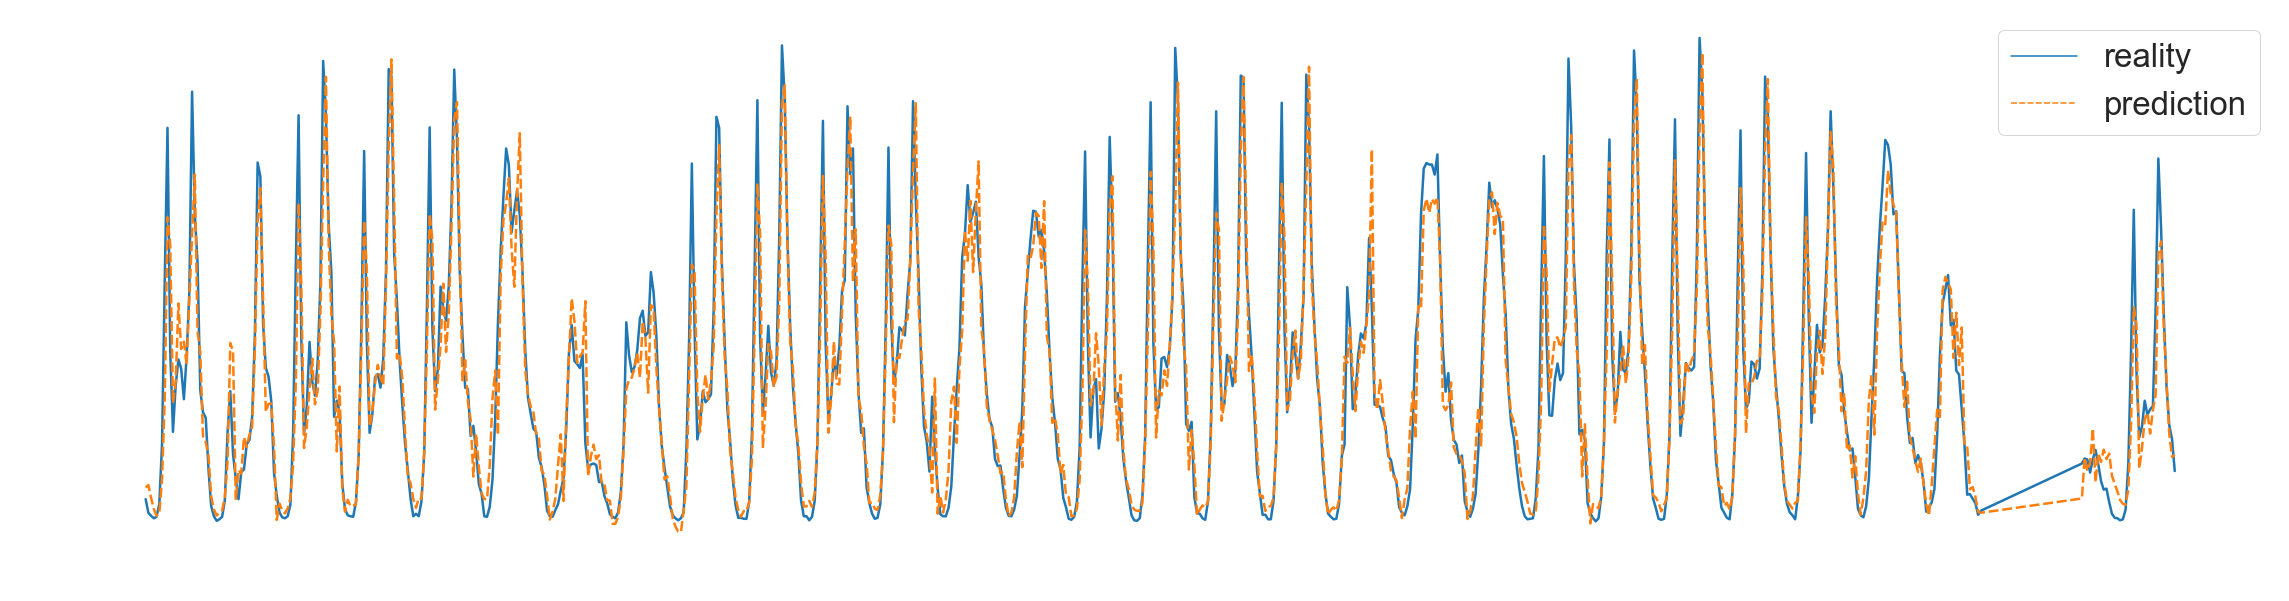

In [83]:
### linear regression
exclude = ['cnt', 'registered','casual', 'dteday','season','mnth','windspeed','Gas_Price','day']
lr666 = lrmodel(df_C_G_W_S_E,exclude,lags=True)
m,x_holdout,y_holdout = lr666
y_holdout['prediction'] = m.predict(x_holdout)
snsModel(m,y_holdout)

<a id="Conclusion"></a>
## 7. Conclusion<br>
<p>&nbsp;&nbsp;&nbsp;&nbsp;Undoubtedly, we put a lot of effort into trying different things to get the best possible results. Nevertheless, sometimes the “last %” can be very expensive from a computational perspective. This was one of the reasons why we did not choose the model with the highest accuracy. It deserves to mention that at this stage it is crucial to align the business requirements and resources of a company with the desired model. For instance, some companies might value the “extra accuracy” whereas for others this does not add any additional value. We believe that our results can help a company to keep competitors at a distance and reach the “winner takes it all” level. The offered services among the different bike sharing companies are very similar and thus accurate models will be key to succeed in the future.</p>